In [1]:
import torch
import tqdm
import os
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from einops import rearrange, repeat
from pathlib import Path

from hydra import initialize, compose
from hydra.utils import instantiate
import pytorch_lightning
from pytorch_lightning.utilities import move_data_to_device
from torchmetrics import ConfusionMatrix

from bliss.surveys.dc2 import DC2DataModule
from bliss.catalog import TileCatalog, convert_flux_to_magnitude
from case_studies.dc2_cataloging.utils.encoder import CalibrationEncoder

In [2]:
model_name = "exp_03-17-1"
model_check_point_name = "encoder_19.ckpt"
model_path = f"../../../bliss_output/DC2_cataloging_exp/{model_name}/checkpoints/{model_check_point_name}"
cached_data_path = Path("/data/scratch/pduan/posterior_cached_files")
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
with initialize(config_path="./", version_base=None):
    new_diffusion_notebook_cfg = compose("notebook_config")

In [3]:
seed = 7272
pytorch_lightning.seed_everything(seed=seed)

Seed set to 7272


7272

In [4]:
tile_slen = new_diffusion_notebook_cfg.surveys.dc2.tile_slen
max_sources_per_tile = new_diffusion_notebook_cfg.surveys.dc2.max_sources_per_tile
r_band_min_flux = new_diffusion_notebook_cfg.notebook_var.r_band_min_flux

batch_size = 800
dc2: DC2DataModule = instantiate(new_diffusion_notebook_cfg.surveys.dc2)
dc2.batch_size = batch_size
dc2.setup(stage="validate")
dc2_val_dataloader = dc2.val_dataloader()

bliss_encoder: CalibrationEncoder = instantiate(new_diffusion_notebook_cfg.encoder).to(device=device)
pretrained_weights = torch.load(model_path, map_location=device)["state_dict"]
bliss_encoder.load_state_dict(pretrained_weights)
bliss_encoder.eval();

In [5]:
one_batch = next(iter(dc2_val_dataloader))
one_batch = move_data_to_device(one_batch, device=device)

In [6]:
target_tile_cat = TileCatalog(one_batch["tile_catalog"])
target_images = one_batch["images"]
target_n_sources = target_tile_cat["n_sources"]
target_tile_cat = target_tile_cat.get_brightest_sources_per_tile(band=2)
target_locs = target_tile_cat["locs"]
target_fluxes = target_tile_cat["fluxes"]
target_ellipticity = target_tile_cat["ellipticity"]

In [7]:
total_iters = 1000
bliss_cached_file_name = f"bliss_posterior_{model_name}_{model_check_point_name}_b_{batch_size}_iter_{total_iters}_seed_{seed}.pt"
if not os.path.isfile(cached_data_path / bliss_cached_file_name):
    print("can't find cached file; rerun the inference")
    init_n_sources = None
    n_sources_list = []
    locs_list = []
    fluxes_list = []
    ellipticity_list = []
    for i in tqdm.tqdm(range(total_iters)):
        with torch.no_grad():
            sample_tile_cat = bliss_encoder.sample(one_batch, use_mode=False)
        if init_n_sources is None:
            init_n_sources = sample_tile_cat["n_sources"]  # (b, h, w)
        cur_n_sources = sample_tile_cat["n_sources"]
        init_n_sources_mask = init_n_sources > 0
        cur_n_sources_mask = cur_n_sources > 0
        nan_mask = (~(init_n_sources_mask & cur_n_sources_mask)) & init_n_sources_mask
        nan_mask = rearrange(nan_mask, "b h w -> b h w 1 1")
        n_sources_list.append(cur_n_sources.cpu())
        locs = sample_tile_cat["locs"][..., 0:1, :]  # (b, h, w, 1, 2)
        locs_list.append(
            torch.where(nan_mask, torch.nan, locs).cpu()
        )
        fluxes = sample_tile_cat["fluxes"][..., 0:1, :]  # (b, h, w, 1, 6)
        fluxes_list.append(
            torch.where(nan_mask, torch.nan, fluxes).cpu()
        )
        ellipticity = sample_tile_cat["ellipticity"][..., 0:1, :]  # (b, h, w, 1, 2)
        ellipticity_list.append(
            torch.where(nan_mask, torch.nan, ellipticity).cpu()
        )

    bliss_result_dict = {
        "init_n_sources": init_n_sources.cpu(),
        "n_sources_list": n_sources_list,
        "locs_list": locs_list,
        "fluxes_list": fluxes_list,
        "ellipticity_list": ellipticity_list,
        "target_images": target_images.cpu(),
        "target_n_sources": target_n_sources.cpu(),
        "target_locs": target_locs.cpu(),
        "target_fluxes": target_fluxes.cpu(),
        "target_ellipticity": target_ellipticity.cpu(),
    }
    torch.save(bliss_result_dict, cached_data_path / bliss_cached_file_name)
else:
    print("find the cached file; directly use it")
    with open(cached_data_path / bliss_cached_file_name, "rb") as f:
        bliss_result_dict = torch.load(f, map_location="cpu")

find the cached file; directly use it


In [8]:
diffusion_cached_file_name = "diffusion_posterior_exp_03-16-3_encoder_113.ckpt_b_128_iter_100_seed_7272.pt"
with open(cached_data_path / diffusion_cached_file_name, "rb") as f:
    diffusion_result_dict = torch.load(f, map_location="cpu")

### Locs CI

In [9]:
def get_locs_ci(on_mask_locs, on_mask_target_locs, both_on_mask,
                ci_cover: list[float], for_vertical_locs: bool):
    left_q_points = [(1.0 - c) / 2 for c in ci_cover]
    right_q_points = [1.0 - lq for lq in left_q_points]
    actual_ci_cover = []
    if for_vertical_locs:
        locs_index = 0
    else:
        locs_index = 1

    for q in zip(left_q_points, right_q_points):
        q = torch.tensor(q)
        on_mask_locs_q = on_mask_locs.nanquantile(q=q, dim=-2).permute([1, 2, 0])  # (matched_sources, 2, 2)
        above_lower_bound = on_mask_target_locs[:, locs_index] > on_mask_locs_q[:, locs_index, 0]
        below_upper_bound = on_mask_target_locs[:, locs_index] < on_mask_locs_q[:, locs_index, 1]
        actual_ci_cover.append((above_lower_bound & below_upper_bound).sum() / both_on_mask.sum())
    return actual_ci_cover

In [10]:
def plot_data_for_locs_ci(result_dict, ci_cover):
    init_n_sources = result_dict["init_n_sources"]
    locs_list = result_dict["locs_list"]
    target_n_sources = result_dict["target_n_sources"]
    target_locs = result_dict["target_locs"]

    both_on_mask = (target_n_sources > 0) & (init_n_sources > 0)  # (b, h, w)
    all_locs = torch.cat(locs_list, dim=-2)  # (b, h, w, iter, 2)
    both_on_mask_iter_repeated = repeat(both_on_mask, 
                                        "b h w -> b h w iter k",
                                        iter=all_locs.shape[-2],
                                        k=all_locs.shape[-1])  # (b, h, w, iter, 2)
    both_on_mask_single_repeated = repeat(both_on_mask, 
                                        "b h w -> b h w 1 k",
                                        k=all_locs.shape[-1])  # (b, h, w, 1, 2)
    on_mask_locs = all_locs[both_on_mask_iter_repeated].view(-1, all_locs.shape[-2], 2)  # (matched_sources, iter, 2)
    on_mask_target_locs = target_locs[both_on_mask_single_repeated].view(-1, 2)  # (matched_sources, 2)
    v_ci_cover = get_locs_ci(on_mask_locs, on_mask_target_locs, both_on_mask,
                             ci_cover=ci_cover,
                             for_vertical_locs=True)
    h_ci_cover = get_locs_ci(on_mask_locs, on_mask_target_locs, both_on_mask,
                             ci_cover=ci_cover,
                             for_vertical_locs=False)
    return v_ci_cover, h_ci_cover

In [11]:
ci_cover = [i / 100 for i in range(5, 100, 5)]
bliss_v_ci_cover, bliss_h_ci_cover = plot_data_for_locs_ci(bliss_result_dict, ci_cover)
diffusion_v_ci_cover, diffusion_h_ci_cover = plot_data_for_locs_ci(diffusion_result_dict, ci_cover)

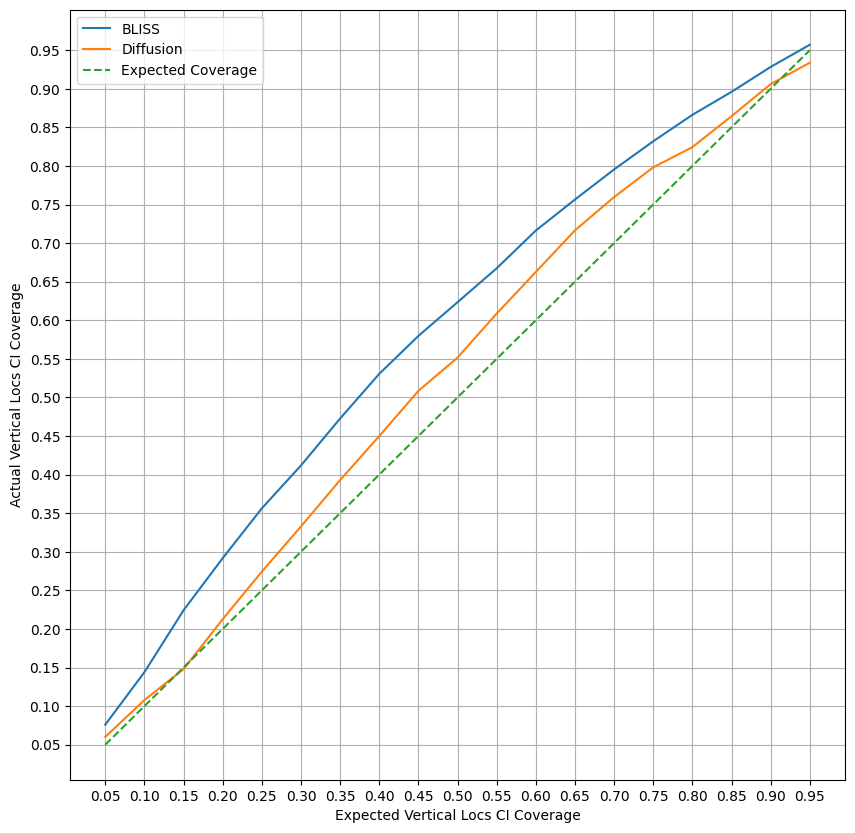

In [12]:
plt.figure(figsize=(10, 10))
plt.plot(ci_cover, bliss_v_ci_cover, label="BLISS")
plt.plot(ci_cover, diffusion_v_ci_cover, label="Diffusion")
plt.plot(ci_cover, ci_cover, linestyle="dashed", label="Expected Coverage")
plt.xlabel("Expected Vertical Locs CI Coverage")
plt.ylabel("Actual Vertical Locs CI Coverage")
plt.legend()
plt.xticks(ci_cover)
plt.yticks(ci_cover)
plt.grid()
plt.show()

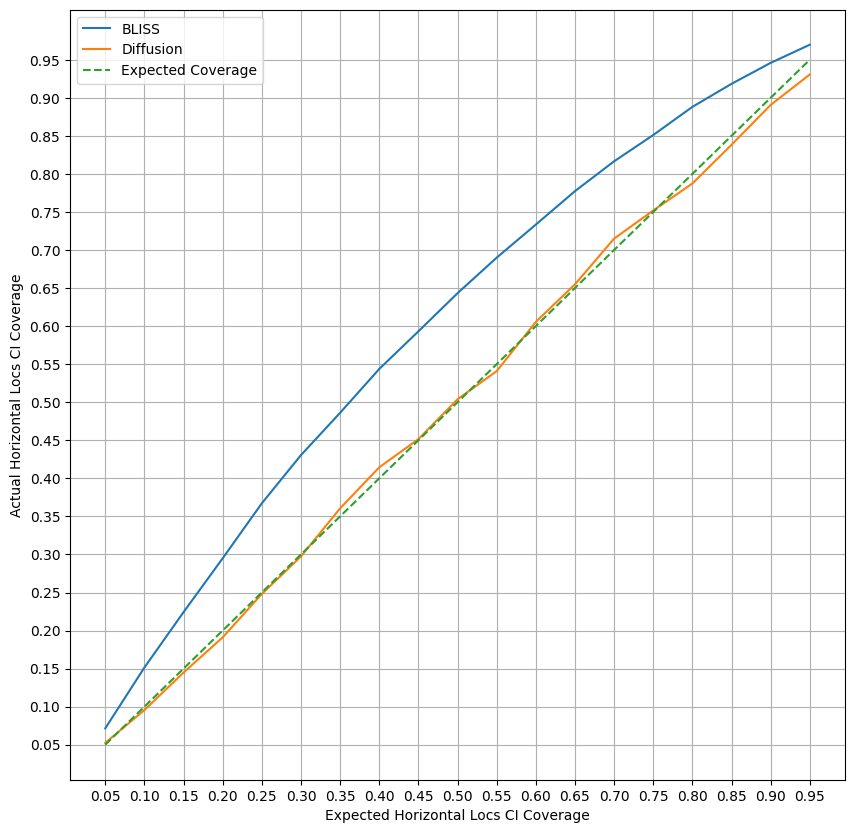

In [13]:
plt.figure(figsize=(10, 10))
plt.plot(ci_cover, bliss_h_ci_cover, label="BLISS")
plt.plot(ci_cover, diffusion_h_ci_cover, label="Diffusion")
plt.plot(ci_cover, ci_cover, linestyle="dashed", label="Expected Coverage")
plt.xlabel("Expected Horizontal Locs CI Coverage")
plt.ylabel("Actual Horizontal Locs CI Coverage")
plt.legend()
plt.xticks(ci_cover)
plt.yticks(ci_cover)
plt.grid()
plt.show()

### N Sources CI

In [14]:
def plot_data_for_n_sources_ci(result_dict):
    n_sources_list = result_dict["n_sources_list"]
    target_n_sources = result_dict["target_n_sources"]

    est_n_sources_percent = (torch.stack(n_sources_list, dim=-1) > 0).float().mean(dim=-1)
    target_n_sources_mask = target_n_sources > 0

    boundaries = torch.tensor([-0.1, ] + [i / 100 for i in range(10, 100, 10)] + [1.1, ])
    est_n_sources_percent_bin = torch.bucketize(est_n_sources_percent, boundaries=boundaries)
    est_n_sources_percent_bin -= 1
    bins = list(zip(boundaries[:-1].tolist(), boundaries[1:].tolist()))

    bin_masks = [est_n_sources_percent_bin == i for i in range(len(bins))]
    true_n_sources_percent = [(target_n_sources_mask[m].sum() / m.sum()).item() for m in bin_masks]
    return bins, true_n_sources_percent, est_n_sources_percent_bin

In [15]:
bins, bliss_true_ns_percent, bliss_est_ns_percent_bin = plot_data_for_n_sources_ci(bliss_result_dict)
_, diffusion_true_ns_percent, _ = plot_data_for_n_sources_ci(diffusion_result_dict)

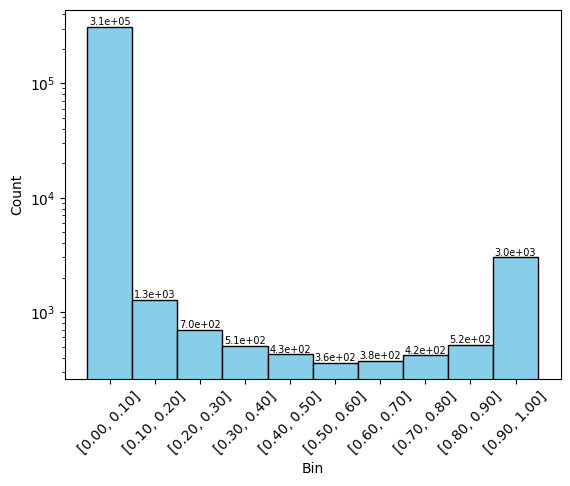

In [16]:
x = list(range(len(bins)))
_, _, patches = plt.hist(bliss_est_ns_percent_bin.flatten(), 
                         bins=x + [len(bins), ], log=True,
                         edgecolor="black", facecolor="skyblue")
plt.bar_label(patches, fmt="%.1e", fontsize=7)
plt.xlabel("Bin")
plt.xticks([xx + 0.5 for xx in x], 
           labels=["[0.00, 0.10]", ] + \
                  [f"[{bl:.2f}, {br:.2f}]" for bl, br in bins[1:-1]] + \
                  ["[0.90, 1.00]", ], 
           rotation=45)
plt.ylabel("Count")
plt.show()

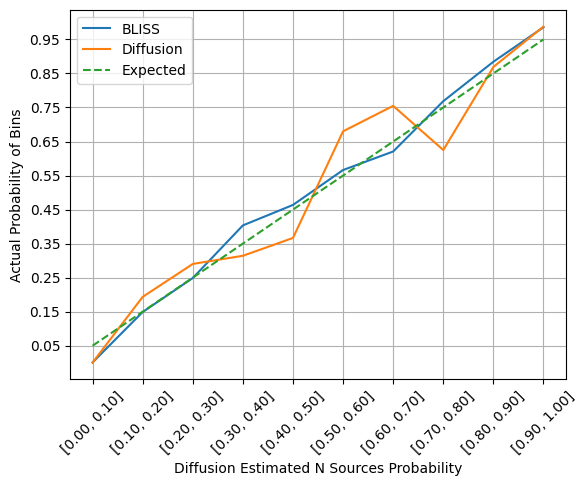

In [17]:
refer_n_sources_prob = [i / 100 for i in range(5, 96, 10)]
x = list(range(len(bins)))
plt.plot(x, bliss_true_ns_percent, label="BLISS")
plt.plot(x, diffusion_true_ns_percent, label="Diffusion")
plt.plot(x, refer_n_sources_prob, linestyle="dashed", label="Expected")
plt.yticks(refer_n_sources_prob)
plt.xticks(x, 
           labels=["[0.00, 0.10]", ] + \
                  [f"[{bl:.2f}, {br:.2f}]" for bl, br in bins[1:-1]] + \
                  ["[0.90, 1.00]", ], 
           rotation=45)
plt.xlabel("Diffusion Estimated N Sources Probability")
plt.ylabel("Actual Probability of Bins")
plt.grid()
plt.legend()
plt.show()

### N Sources Confusion Matrix

In [18]:
def plot_data_for_n_sources_cm(result_dict):
    n_sources_list = result_dict["n_sources_list"]
    target_n_sources = result_dict["target_n_sources"]  # (b, h, w)

    est_n_sources = torch.stack(n_sources_list, dim=-1).clamp(max=3)  # (b, h, w, r)
    target_n_sources = repeat(target_n_sources, "b h w -> b h w r", r=est_n_sources.shape[-1]).clamp(max=3)
    confmat = ConfusionMatrix(task="multiclass", num_classes=4)
    cm = confmat(target_n_sources.flatten(), est_n_sources.flatten())
    cm_d = torch.minimum(cm, cm.T)
    cm_f = ((cm - cm.T) / cm_d).nan_to_num(0.0, posinf=0.0, neginf=0.0)
    return cm, cm_f

In [19]:
bliss_n_sources_cm, bliss_n_sources_cm_f = plot_data_for_n_sources_cm(bliss_result_dict)

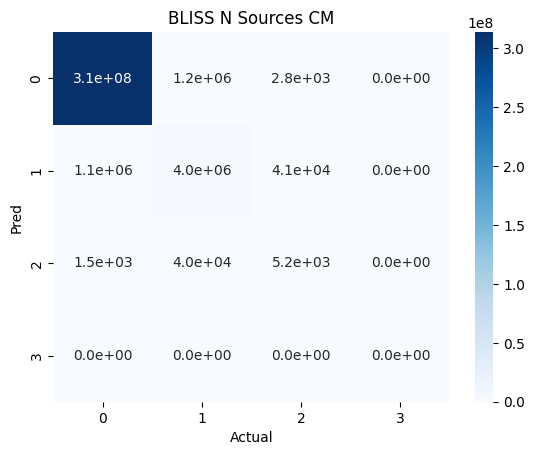

In [20]:
sns.heatmap(bliss_n_sources_cm,
            annot=True,
            fmt=".1e", cmap="Blues", cbar=True)
plt.xlabel("Actual")
plt.ylabel("Pred")
plt.title("BLISS N Sources CM")
plt.show()

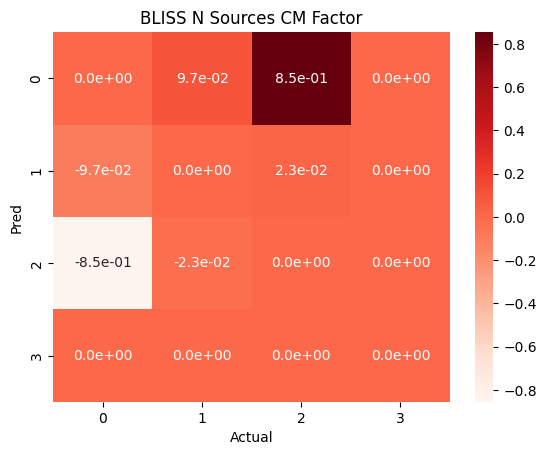

In [21]:
sns.heatmap(bliss_n_sources_cm_f,
            annot=True,
            fmt=".1e", cmap="Reds", cbar=True)
plt.xlabel("Actual")
plt.ylabel("Pred")
plt.title("BLISS N Sources CM Factor")
plt.show()

In [22]:
diffusion_n_sources_cm, diffusion_n_sources_cm_f = plot_data_for_n_sources_cm(diffusion_result_dict)

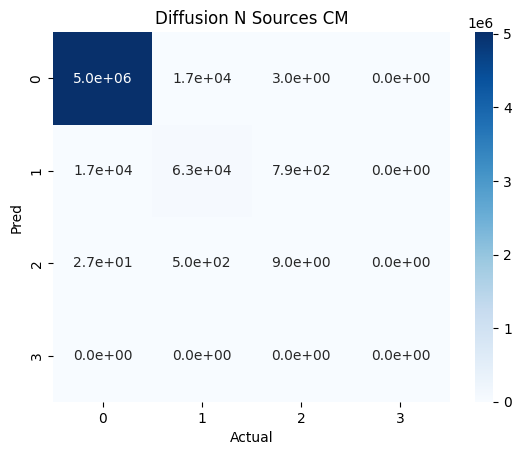

In [23]:
sns.heatmap(diffusion_n_sources_cm,
            annot=True,
            fmt=".1e", cmap="Blues", cbar=True)
plt.xlabel("Actual")
plt.ylabel("Pred")
plt.title("Diffusion N Sources CM")
plt.show()

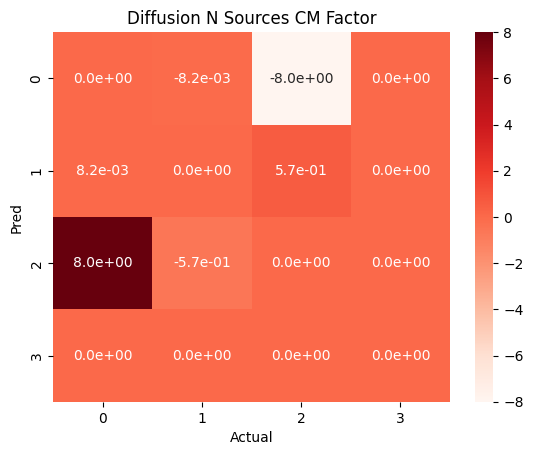

In [24]:
sns.heatmap(diffusion_n_sources_cm_f,
            annot=True,
            fmt=".1e", cmap="Reds", cbar=True)
plt.xlabel("Actual")
plt.ylabel("Pred")
plt.title("Diffusion N Sources CM Factor")
plt.show()

### Boundary N Sources

In [25]:
def calculate_boundary_n_sources(result_dict, boundary_width, pad_width):
    n_sources_list = result_dict["n_sources_list"]
    target_n_sources = result_dict["target_n_sources"]  # (b, h, w)
    target_locs = result_dict["target_locs"].squeeze(-2)  # (b, h, w, 2)

    top_in_boundary = (target_locs[..., 0] > (1.0 - boundary_width)) & \
                      (target_locs[..., 1] > pad_width) & \
                      (target_locs[..., 1] < (1.0 - pad_width)) & \
                      (target_n_sources > 0)  # (b, h, w)
    top_in_boundary[:, -1, :] = False

    bottom_in_boundary = (target_locs[..., 0] < boundary_width) & \
                      (target_locs[..., 1] > pad_width) & \
                      (target_locs[..., 1] < (1.0 - pad_width)) & \
                      (target_n_sources > 0)
    bottom_in_boundary[:, 0, :] = False

    left_in_boundary = (target_locs[..., 1] < boundary_width) & \
                      (target_locs[..., 0] > pad_width) & \
                      (target_locs[..., 0] < (1.0 - pad_width)) & \
                      (target_n_sources > 0)
    left_in_boundary[:, :, 0] = False

    right_in_boundary = (target_locs[..., 1] > (1.0 - boundary_width)) & \
                        (target_locs[..., 0] > pad_width) & \
                        (target_locs[..., 0] < (1.0 - pad_width)) & \
                        (target_n_sources > 0)
    right_in_boundary[:, :, -1] = False
    
    top_in_boundary_shift = torch.roll(top_in_boundary, shifts=1, dims=1)
    top_in_boundary_shift[:, 0, :] = False
    
    bottom_in_boundary_shift = torch.roll(bottom_in_boundary, shifts=-1, dims=1)
    bottom_in_boundary_shift[:, -1, :] = False

    left_in_boundary_shift = torch.roll(left_in_boundary, shifts=-1, dims=2)
    left_in_boundary_shift[:, :, -1] = False

    right_in_boundary_shift = torch.roll(right_in_boundary, shifts=1, dims=2)
    right_in_boundary_shift[:, :, 0] = False

    est_n_sources_percent = torch.stack(n_sources_list, dim=-1).float().mean(dim=-1)  # (b, h, w)
    return {
        "top_in_b": top_in_boundary,
        "top_in_b_shift": top_in_boundary_shift,
        "bottom_in_b": bottom_in_boundary,
        "bottom_in_b_shift": bottom_in_boundary_shift,
        "left_in_b": left_in_boundary,
        "left_in_b_shift": left_in_boundary_shift,
        "right_in_b": right_in_boundary,
        "right_in_b_shift": right_in_boundary_shift,
        "est_ns_percent": est_n_sources_percent,
        "top_in_b_ns_percent": est_n_sources_percent[top_in_boundary],
        "top_in_b_shift_ns_percent": est_n_sources_percent[top_in_boundary_shift],
        "bottom_in_b_ns_percent": est_n_sources_percent[bottom_in_boundary],
        "bottom_in_b_shift_ns_percent": est_n_sources_percent[bottom_in_boundary_shift],
        "left_in_b_ns_percent": est_n_sources_percent[left_in_boundary],
        "left_in_b_shift_ns_percent": est_n_sources_percent[left_in_boundary_shift],
        "right_in_b_ns_percent": est_n_sources_percent[right_in_boundary],
        "right_in_b_shift_ns_percent": est_n_sources_percent[right_in_boundary_shift],
    }
    

In [26]:
bliss_b_ns_dict = calculate_boundary_n_sources(bliss_result_dict, boundary_width=0.02, pad_width=0.2)

In [27]:
for k, v in bliss_b_ns_dict.items():
    print(f"{k}: {v.float().mean().item():.4f}")

top_in_b: 0.0002
top_in_b_shift: 0.0002
bottom_in_b: 0.0002
bottom_in_b_shift: 0.0002
left_in_b: 0.0002
left_in_b_shift: 0.0002
right_in_b: 0.0002
right_in_b_shift: 0.0002
est_ns_percent: 0.0162
top_in_b_ns_percent: 0.4976
top_in_b_shift_ns_percent: 0.4089
bottom_in_b_ns_percent: 0.5778
bottom_in_b_shift_ns_percent: 0.3303
left_in_b_ns_percent: 0.5839
left_in_b_shift_ns_percent: 0.2921
right_in_b_ns_percent: 0.4711
right_in_b_shift_ns_percent: 0.4481


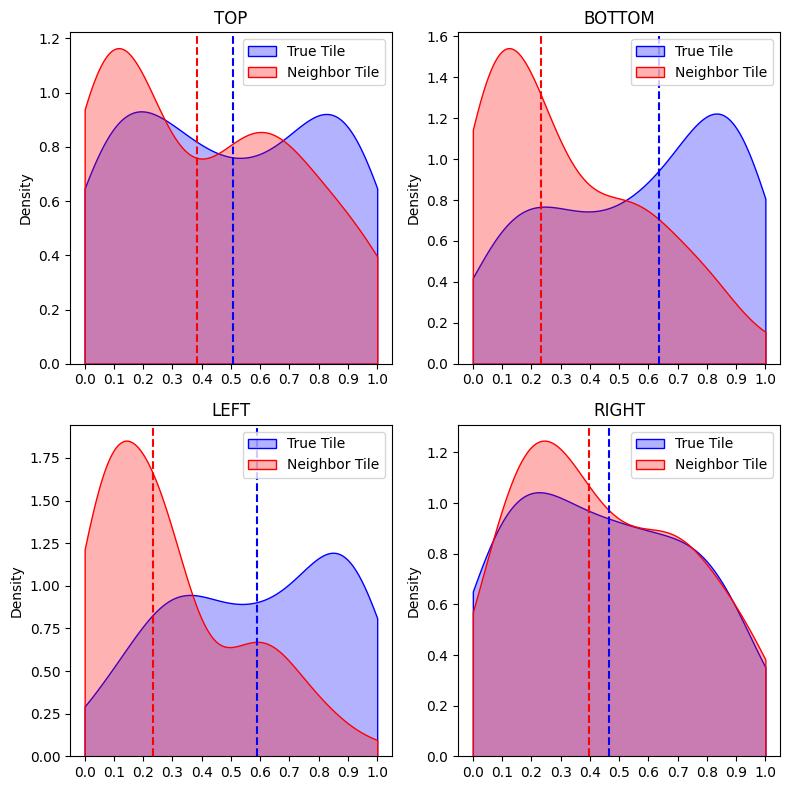

In [28]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
for ax, direction in zip(axes.flatten(), ["top", "bottom", "left", "right"]):
    sns.kdeplot(bliss_b_ns_dict[f"{direction}_in_b_ns_percent"], 
                fill=True, label="True Tile", color="blue", alpha=0.3, bw_adjust=1,
                clip=(0.0, 1.0), ax=ax)
    ax.axvline(x=bliss_b_ns_dict[f"{direction}_in_b_ns_percent"].median(), 
               color="blue", linewidth=1.5, linestyle="dashed")
    sns.kdeplot(bliss_b_ns_dict[f"{direction}_in_b_shift_ns_percent"], 
                fill=True, label="Neighbor Tile", color="red", alpha=0.3, bw_adjust=1,
                clip=(0.0, 1.0), ax=ax)
    ax.axvline(x=bliss_b_ns_dict[f"{direction}_in_b_shift_ns_percent"].median(), 
               color="red", linewidth=1.5, linestyle="dashed")
    ax.set_xticks([i / 100 for i in range(0, 101, 10)])
    ax.set_title(direction.upper())
    ax.legend()
fig.tight_layout()
fig.show()

In [29]:
diffusion_b_ns_dict = calculate_boundary_n_sources(diffusion_result_dict, boundary_width=0.02, pad_width=0.2)

In [30]:
for k, v in diffusion_b_ns_dict.items():
    print(f"{k}: {v.float().mean().item():.4f}")

top_in_b: 0.0001
top_in_b_shift: 0.0001
bottom_in_b: 0.0003
bottom_in_b_shift: 0.0003
left_in_b: 0.0002
left_in_b_shift: 0.0002
right_in_b: 0.0001
right_in_b_shift: 0.0001
est_ns_percent: 0.0160
top_in_b_ns_percent: 0.3733
top_in_b_shift_ns_percent: 0.5283
bottom_in_b_ns_percent: 0.5885
bottom_in_b_shift_ns_percent: 0.3177
left_in_b_ns_percent: 0.4855
left_in_b_shift_ns_percent: 0.4227
right_in_b_ns_percent: 0.4050
right_in_b_shift_ns_percent: 0.5775


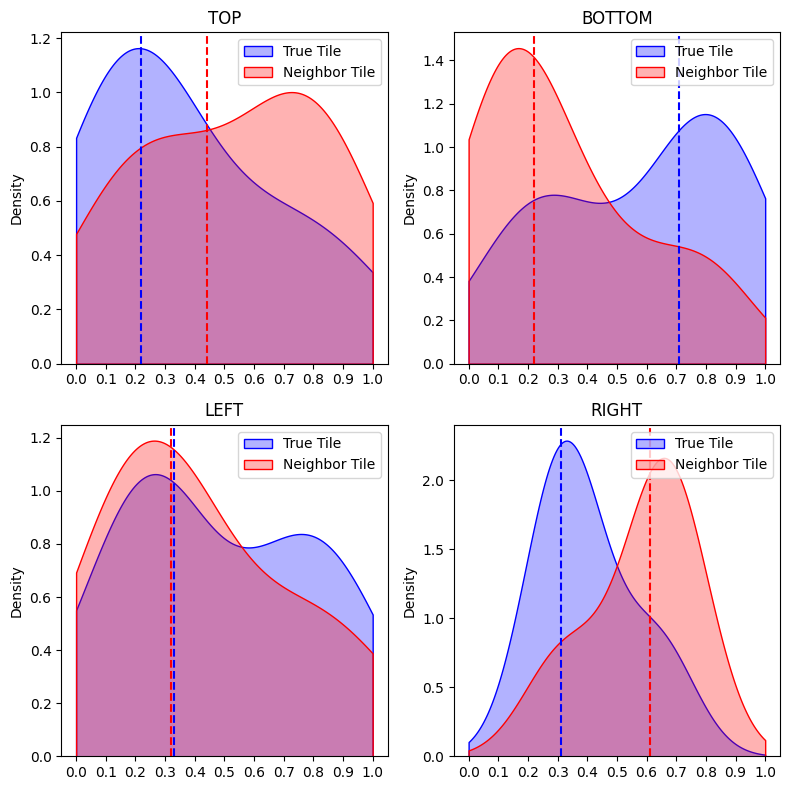

In [31]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
for ax, direction in zip(axes.flatten(), ["top", "bottom", "left", "right"]):
    sns.kdeplot(diffusion_b_ns_dict[f"{direction}_in_b_ns_percent"], 
                fill=True, label="True Tile", color="blue", alpha=0.3, bw_adjust=1,
                clip=(0.0, 1.0), ax=ax)
    ax.axvline(x=diffusion_b_ns_dict[f"{direction}_in_b_ns_percent"].median(), 
               color="blue", linewidth=1.5, linestyle="dashed")
    sns.kdeplot(diffusion_b_ns_dict[f"{direction}_in_b_shift_ns_percent"], 
                fill=True, label="Neighbor Tile", color="red", alpha=0.3, bw_adjust=1,
                clip=(0.0, 1.0), ax=ax)
    ax.axvline(x=diffusion_b_ns_dict[f"{direction}_in_b_shift_ns_percent"].median(), 
               color="red", linewidth=1.5, linestyle="dashed")
    ax.set_xticks([i / 100 for i in range(0, 101, 10)])
    ax.set_title(direction.upper())
    ax.legend()
fig.tight_layout()
fig.show()

In [32]:
def plot_boundary_n_sources(result_dict, direction, seed):
    b_ns_dict = calculate_boundary_n_sources(result_dict, boundary_width=0.02, pad_width=0.2)
    match direction:
        case "top" | "bottom" | "left" | "right":
            in_b_mask = b_ns_dict[f"{direction}_in_b"]
            in_b_shift_mask = b_ns_dict[f"{direction}_in_b_shift"]
            est_ns_percent = b_ns_dict["est_ns_percent"]
        case _:
            raise ValueError()
        
    in_b_index = in_b_mask.nonzero()
    r_num = random.Random(seed).randint(0, in_b_index.shape[0] - 1)
    random_b_index = in_b_index[r_num, :]

    r_images = result_dict["target_images"][random_b_index[0]]
    r_target_ns = result_dict["target_n_sources"][random_b_index[0]]  # (h, w)
    r_image_locs = result_dict["target_locs"][random_b_index[0]].squeeze(-2)  # (h, w, 2)
    x = torch.arange(20)
    y = torch.arange(20)
    grid_x, grid_y = torch.meshgrid(x, y, indexing='ij')
    locs_mesh = torch.stack((grid_x, grid_y), dim=-1)
    r_image_plocs = ((r_image_locs + locs_mesh) * 4)[r_target_ns > 0]
    r_in_b_mask = in_b_mask[random_b_index[0]]
    r_in_b_shift_mask = in_b_shift_mask[random_b_index[0]]
    r_est_ns_percent = est_ns_percent[random_b_index[0]]

    r_images = ((r_images + 0.5).norm(dim=0, p=1) / 6).clamp(min=0, max=1)
    r_images *= 255

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.imshow(r_images, cmap="gray", vmin=0, vmax=255)
    line_width = 1.0
    for x in range(0, 80, 4):
        ax.axvline(x=x, color="white", linewidth=line_width)
    for y in range(0, 80, 4):
        ax.axhline(y=y, color="white", linewidth=line_width)
    for point in r_image_plocs:
        circle = plt.Circle((point[1], point[0]), radius=3, edgecolor=None, facecolor="yellow", alpha=0.4)
        ax.add_patch(circle)
    ax.scatter(r_image_plocs[:, 1], r_image_plocs[:, 0], color="red", marker="+", s=100)
    for m_idx in r_in_b_mask.nonzero():
        i = m_idx[0].item() * 4 + 2
        j = m_idx[1].item() * 4 + 2
        ax.text(j, i, f"{direction[0].upper()}1", 
                ha="center", va="center", color="red",
                fontsize=10, fontweight="bold")
    for m_idx in r_in_b_shift_mask.nonzero():
        i = m_idx[0].item() * 4 + 2
        j = m_idx[1].item() * 4 + 2
        ax.text(j, i, f"{direction[0].upper()}2", 
                ha="center", va="center", color="red",
                fontsize=10, fontweight="bold")
    # ax.set_xticks([])
    # ax.set_yticks([])
    ax.set_xlim(0.0, 80.0)
    ax.set_ylim(0.0, 80.0)
    fig.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 8))
    plt.imshow(r_est_ns_percent, origin="lower")
    line_width = 1.0
    for x in range(0, 20, 1):
        plt.axvline(x=x - 0.5, color="white", linewidth=line_width)
    for y in range(0, 20, 1):
        plt.axhline(y=y - 0.5, color="white", linewidth=line_width)
    plt.colorbar()
    plt.show()
    

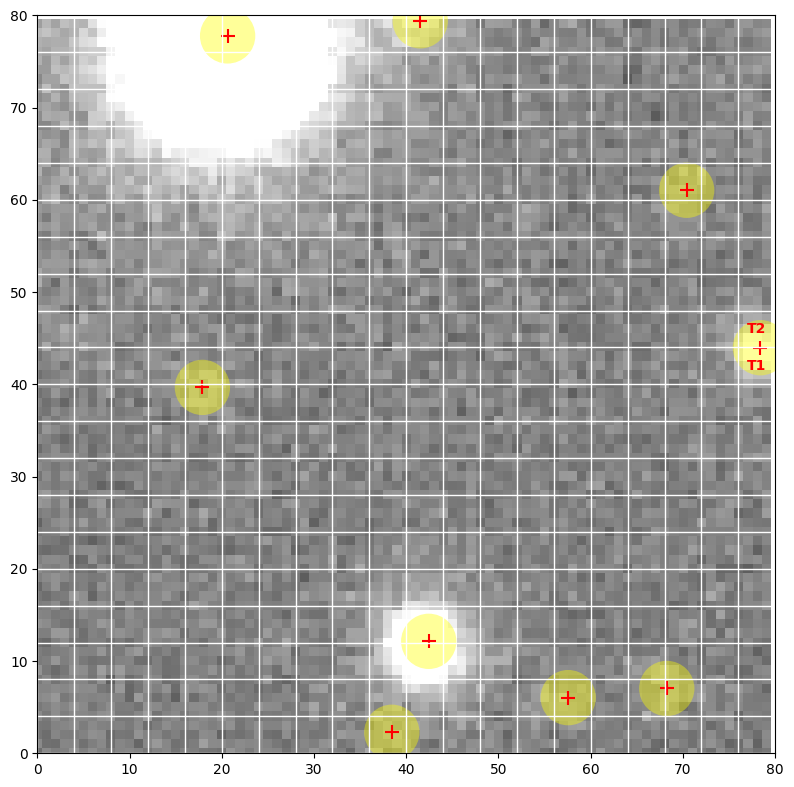

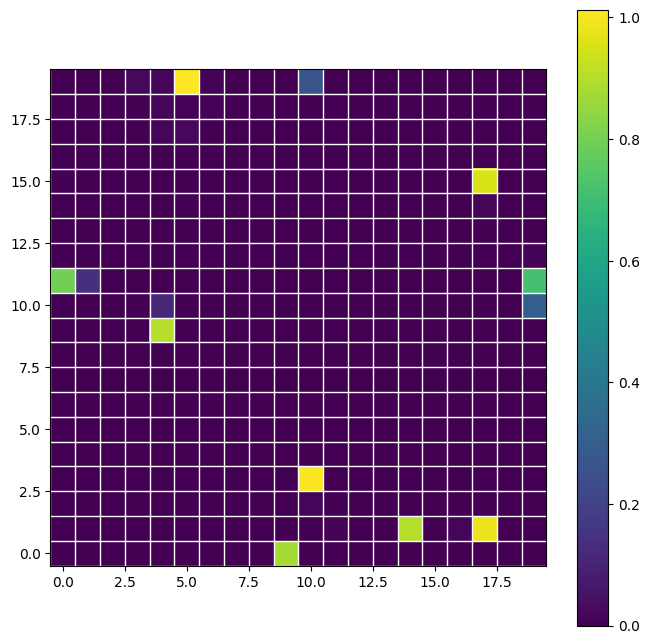

In [33]:
plot_boundary_n_sources(bliss_result_dict, direction="top", seed=1234)

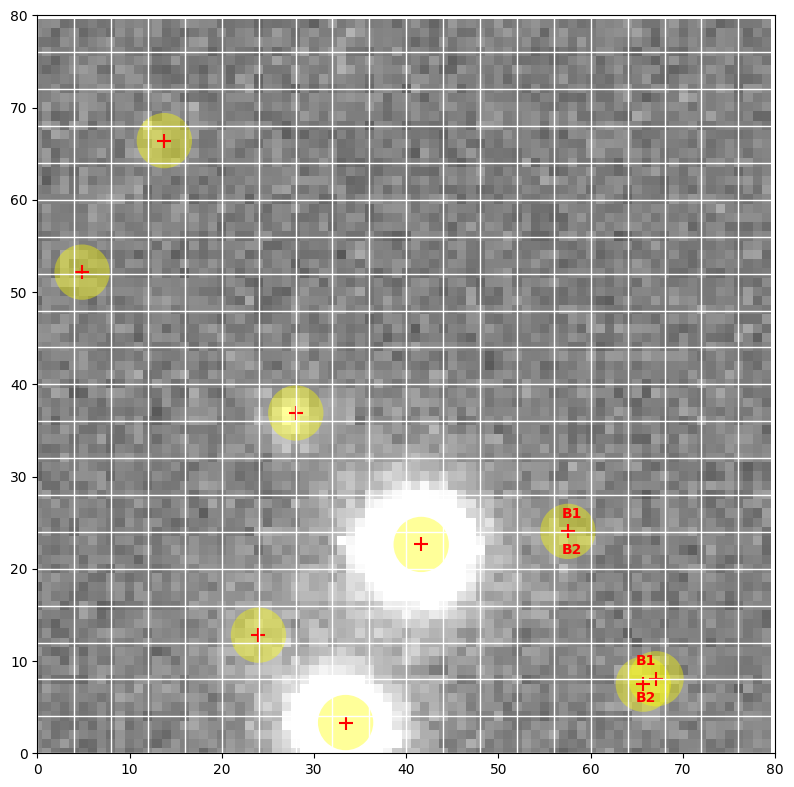

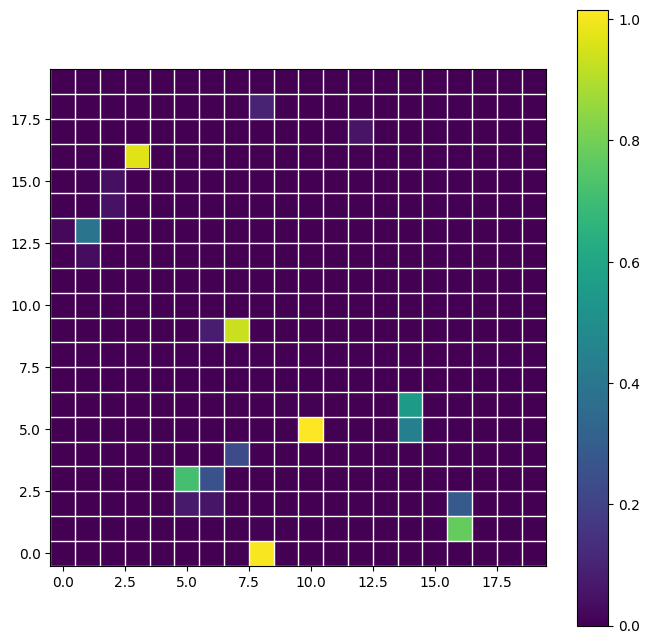

In [34]:
plot_boundary_n_sources(bliss_result_dict, direction="bottom", seed=1234)

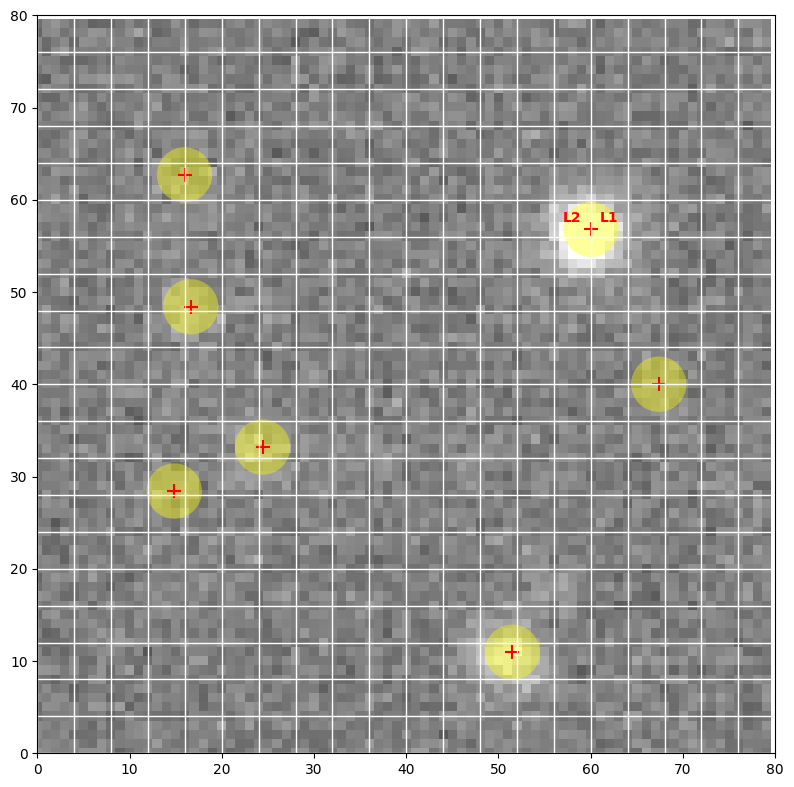

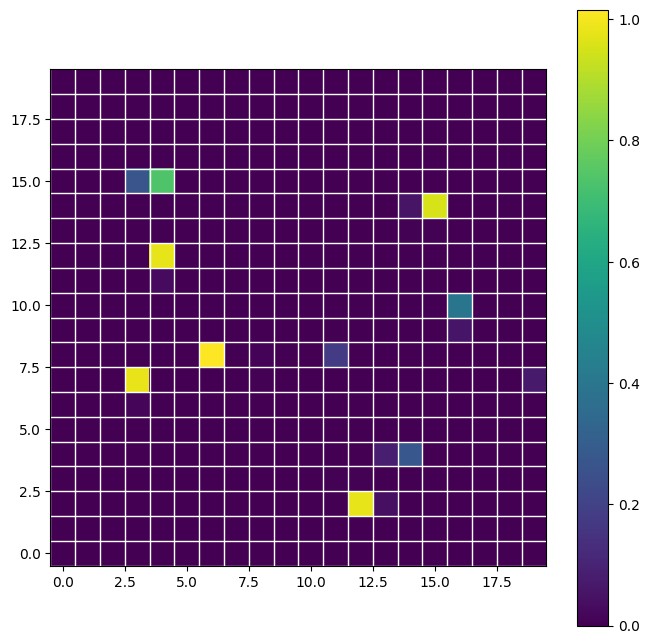

In [35]:
plot_boundary_n_sources(bliss_result_dict, direction="left", seed=1234)

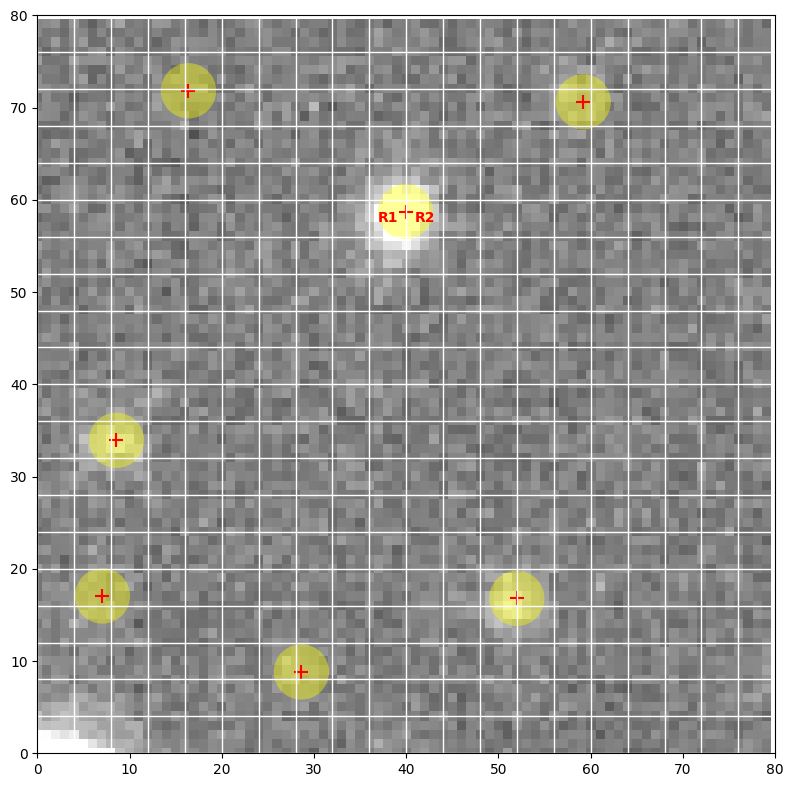

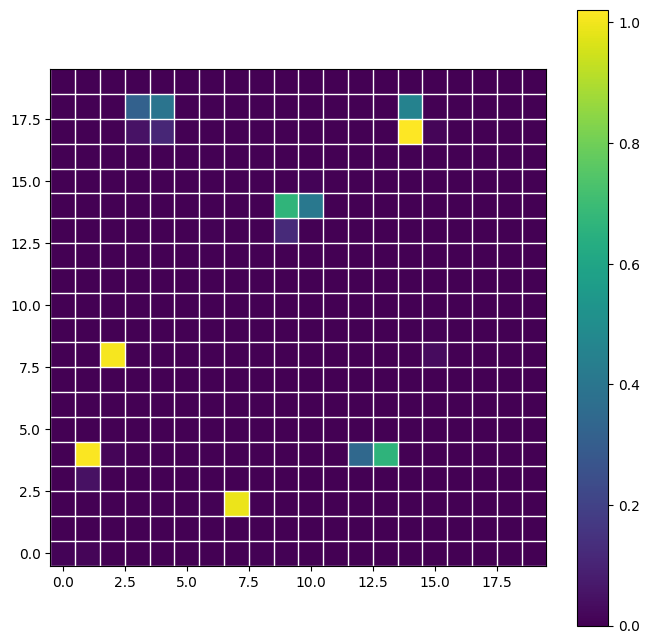

In [36]:
plot_boundary_n_sources(bliss_result_dict, direction="right", seed=1234)

### Fluxes CI

In [37]:
def plot_data_for_fluxes_ci(result_dict, ci_cover, flux_mag_min, flux_mag_max):
    init_n_sources = result_dict["init_n_sources"]
    fluxes_list = result_dict["fluxes_list"]
    target_n_sources = result_dict["target_n_sources"]
    target_fluxes = result_dict["target_fluxes"]

    both_on_mask = (target_n_sources > 0) & (init_n_sources > 0)  # (b, h, w)
    all_fluxes = torch.cat(fluxes_list, dim=-2)  # (b, h, w, iter, 6)
    both_on_mask_iter_repeated = repeat(both_on_mask, 
                                        "b h w -> b h w iter k",
                                        iter=all_fluxes.shape[-2],
                                        k=all_fluxes.shape[-1])  # (b, h, w, iter, 6)
    both_on_mask_single_repeated = repeat(both_on_mask, 
                                        "b h w -> b h w 1 k",
                                        k=all_fluxes.shape[-1])  # (b, h, w, 1, 6)
    on_mask_fluxes = all_fluxes[both_on_mask_iter_repeated].view(-1, all_fluxes.shape[-2], 6)  # (matched_sources, iter, 6)
    on_mask_target_fluxes = target_fluxes[both_on_mask_single_repeated].view(-1, 6)  # (matched_sources, 6)

    left_q_points = [(1.0 - c) / 2 for c in ci_cover]
    right_q_points = [1.0 - lq for lq in left_q_points]
    actual_ci_cover = {band: [] for band in "ugrizy"}
    for q in zip(left_q_points, right_q_points):
        q = torch.tensor(q)
        on_mask_locs_q = on_mask_fluxes.nanquantile(q=q, dim=-2).permute([1, 2, 0])  # (matched_sources, 6, 2)
        for i, band in zip(range(6), "ugrizy"):
            above_lower_bound = on_mask_target_fluxes[:, i] > on_mask_locs_q[:, i, 0]
            below_upper_bound = on_mask_target_fluxes[:, i] < on_mask_locs_q[:, i, 1]  # (matched_sources, )
            on_mask_target_mag = convert_flux_to_magnitude(on_mask_target_fluxes[:, i], zero_point=3631e9)
            valid_on_mask_target_mag = (on_mask_target_mag > flux_mag_min) & (on_mask_target_mag <= flux_mag_max)  # (matched_sources, )
            actual_ci_cover[band].append(((above_lower_bound & below_upper_bound)[valid_on_mask_target_mag].sum() / valid_on_mask_target_mag.sum()).item())
    
    for k, v in actual_ci_cover.items():
        actual_ci_cover[k] = torch.tensor(v)

    return actual_ci_cover

In [38]:
def plot_fluxes_ci(bliss_result_dict, 
                   diffusion_result_dict,
                   flux_mag_min, 
                   flux_mag_max):
    ci_cover = torch.tensor([i / 100 for i in range(5, 100, 5)])
    bliss_fluxes_ci_cover = plot_data_for_fluxes_ci(bliss_result_dict, ci_cover=ci_cover,
                                                    flux_mag_min=flux_mag_min, flux_mag_max=flux_mag_max)
    diffusion_fluxes_ci_cover = plot_data_for_fluxes_ci(diffusion_result_dict, ci_cover=ci_cover,
                                                        flux_mag_min=flux_mag_min, flux_mag_max=flux_mag_max)
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    for ax, band in zip(axes.flatten(), "ugrizy"):
        ax.plot(ci_cover, bliss_fluxes_ci_cover[band], label="BLISS")
        ax.plot(ci_cover, diffusion_fluxes_ci_cover[band], label="Diffusion")
        ax.plot(ci_cover, ci_cover, linestyle="dashed", label="Expected Coverage")
        ax.set_xlabel("Expected CI Coverage")
        ax.set_ylabel("Actual CI Coverage")
        ax.legend()
        ax.set_title(f"Band {band}")
        ax.set_xticks(ci_cover)
        ax.tick_params(axis="x", labelrotation=45)
        ax.set_yticks(ci_cover)
        ax.grid()
    fig.suptitle(f"Magnitude [{flux_mag_min:.1f}, {flux_mag_max:.1f}]")
    fig.tight_layout()
    fig.show()

    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    for ax, band in zip(axes.flatten(), "ugrizy"):
        ax.plot(ci_cover, bliss_fluxes_ci_cover[band] - ci_cover, label="BLISS")
        ax.plot(ci_cover, diffusion_fluxes_ci_cover[band] - ci_cover, label="Diffusion")
        ax.axhline(y=0, linestyle="dashed", label="Expected", color="green")
        ax.set_xlabel("Expected CI Coverage")
        ax.set_ylabel("Actual - Expected CI Coverage")
        ax.legend()
        ax.set_title(f"Band {band}")
        ax.set_xticks(ci_cover)
        ax.tick_params(axis="x", labelrotation=45)
        ax.grid()
    fig.suptitle(f"Magnitude [{flux_mag_min:.1f}, {flux_mag_max:.1f}]")
    fig.tight_layout()
    fig.show()

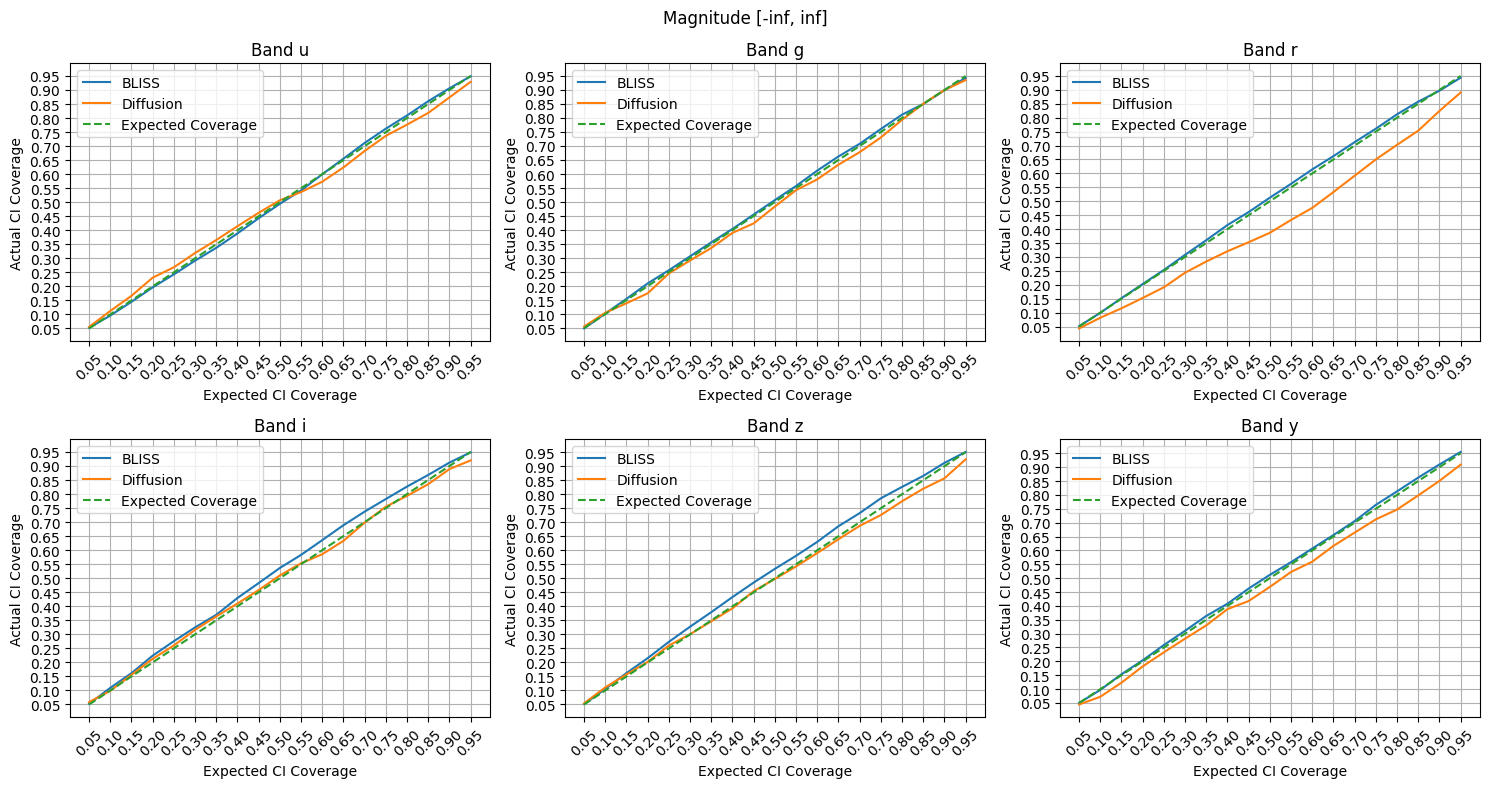

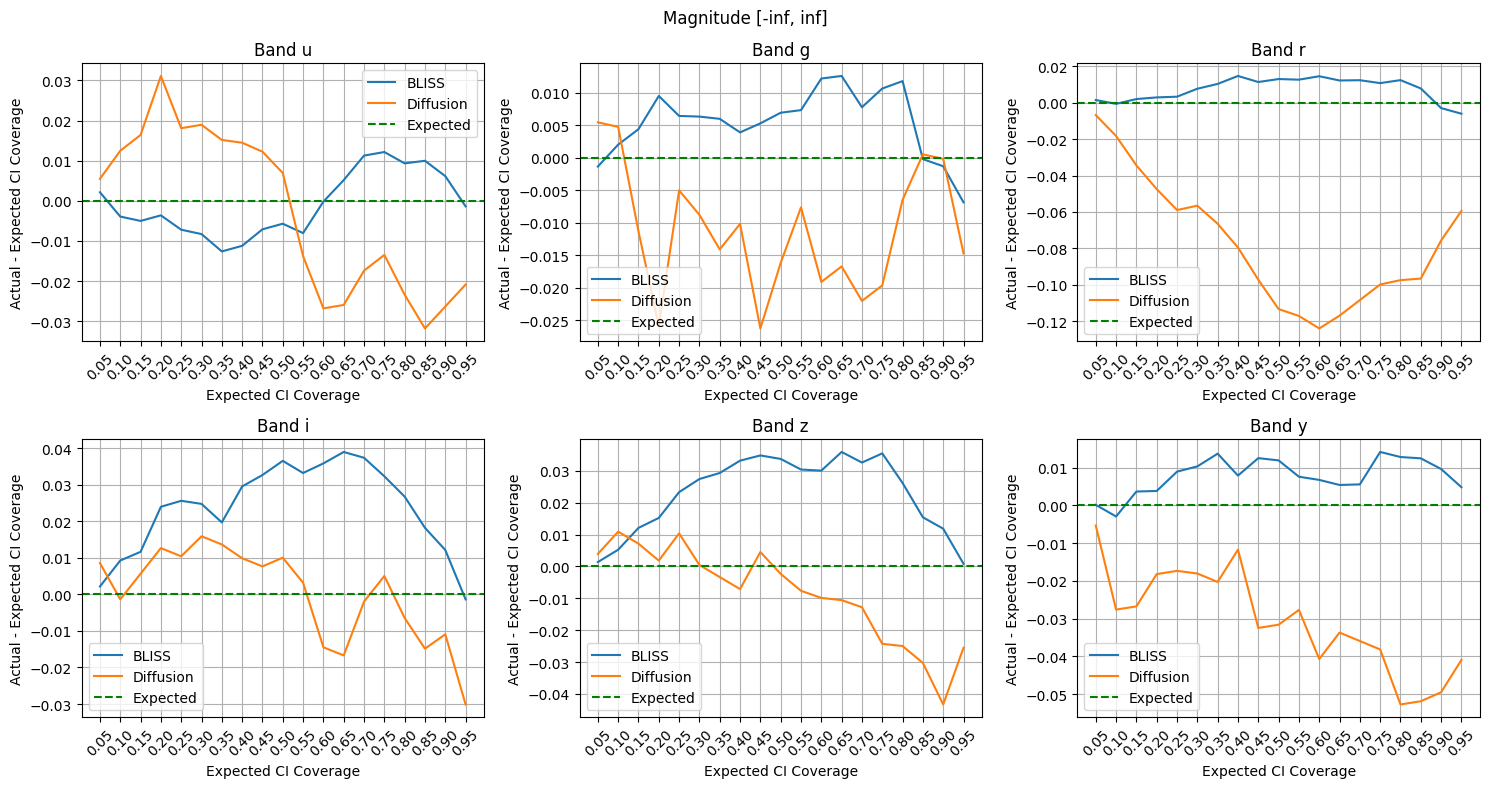

In [39]:
plot_fluxes_ci(bliss_result_dict, diffusion_result_dict, flux_mag_min=-torch.inf, flux_mag_max=torch.inf)

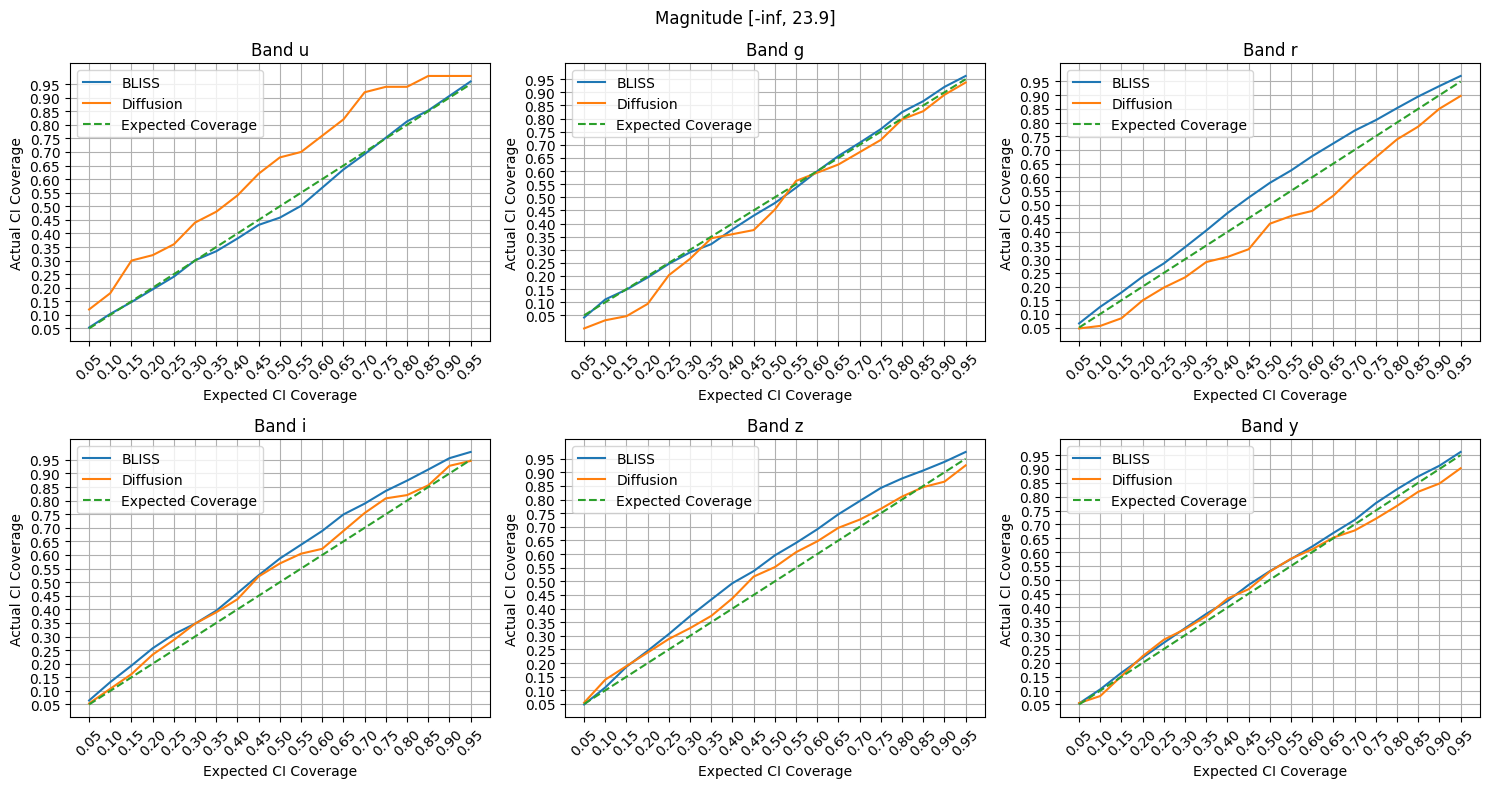

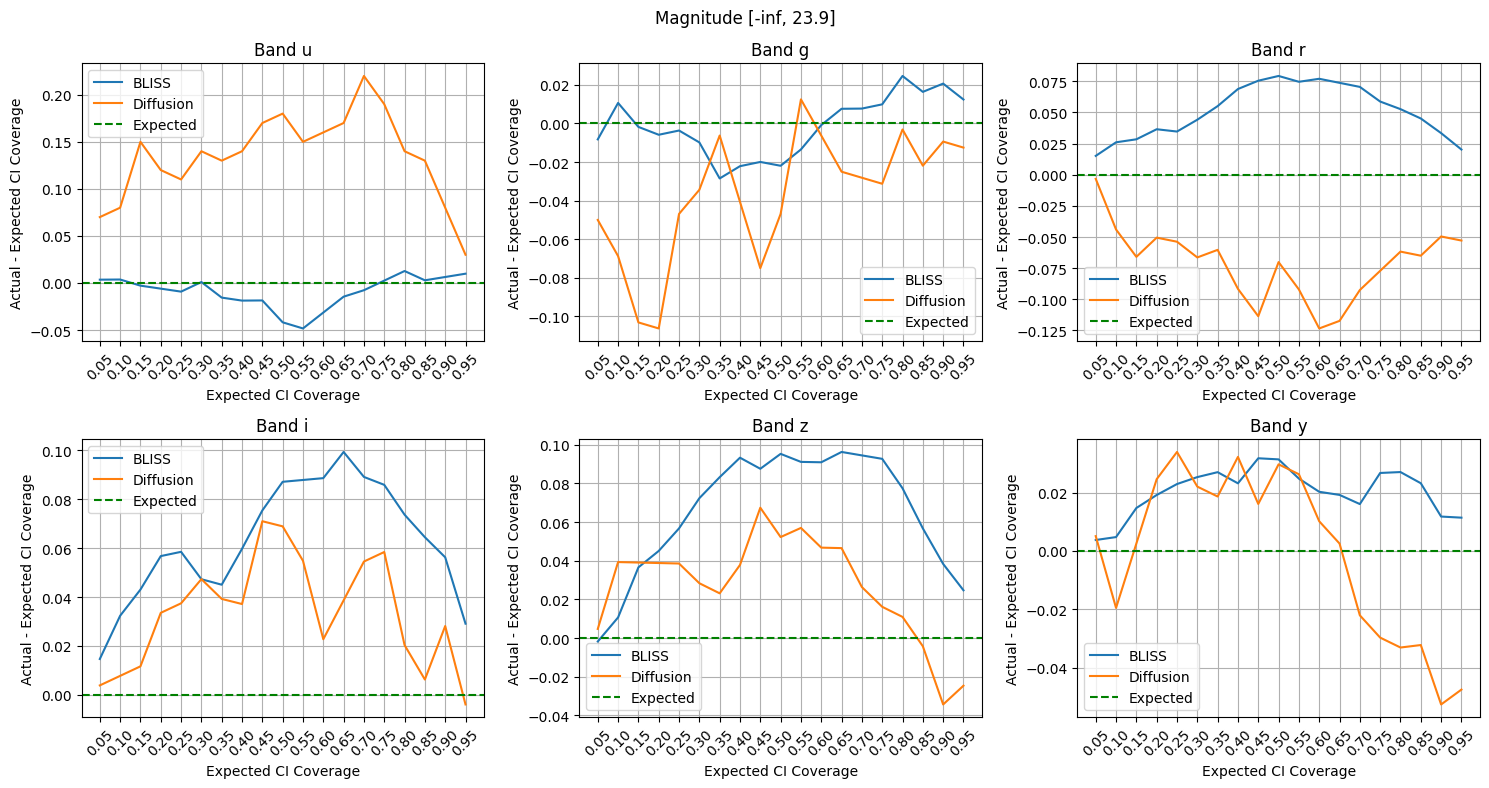

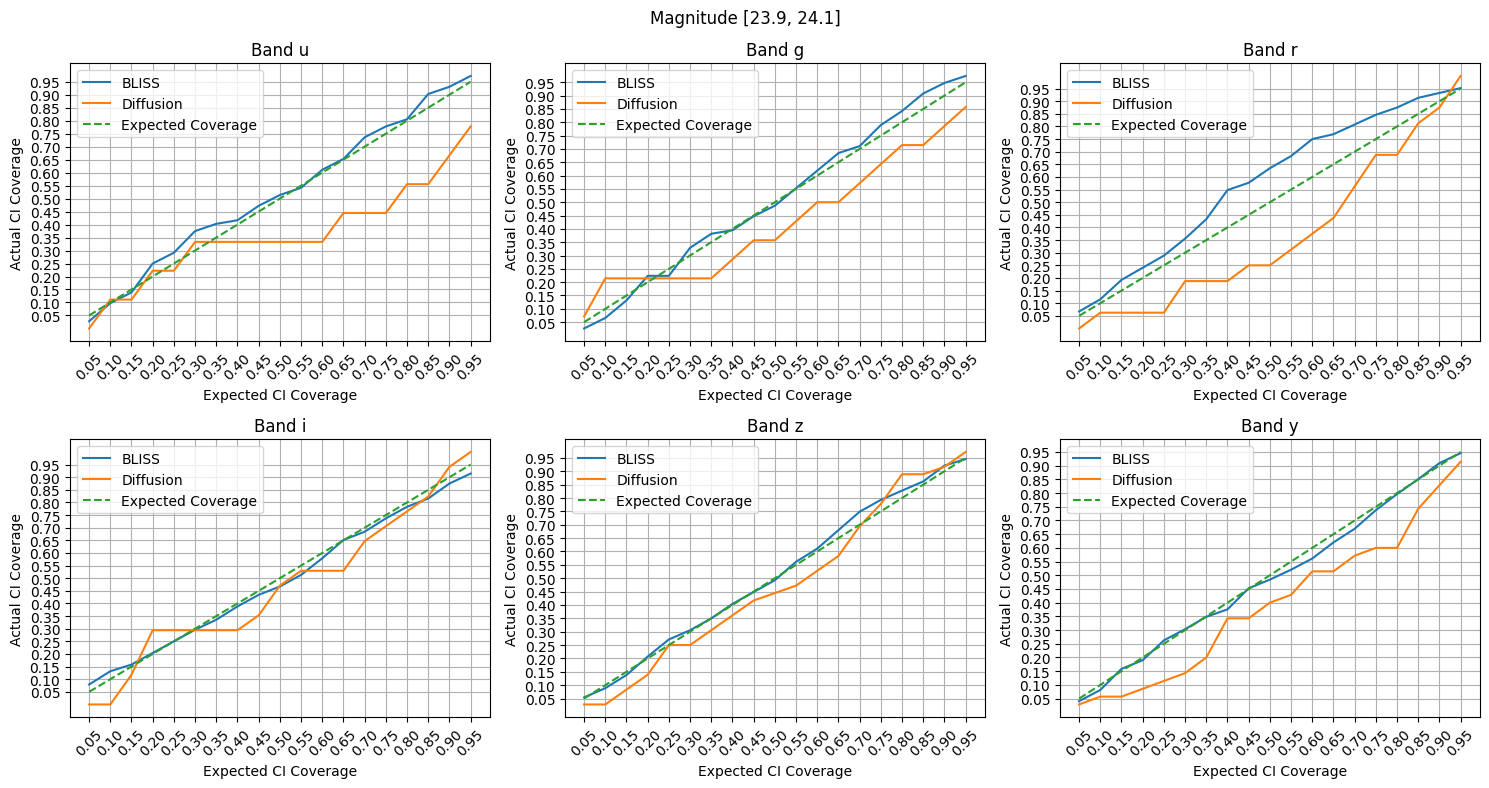

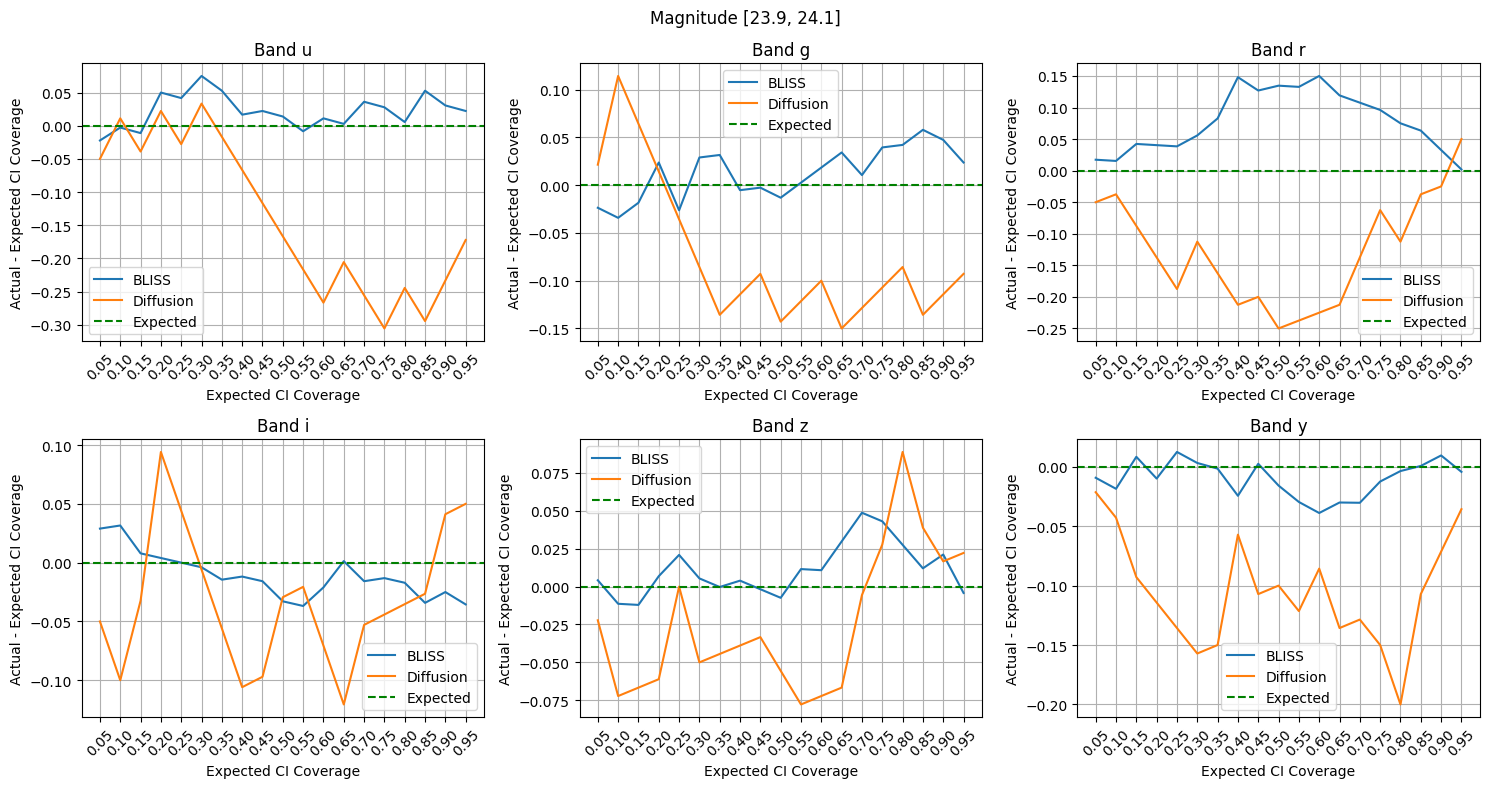

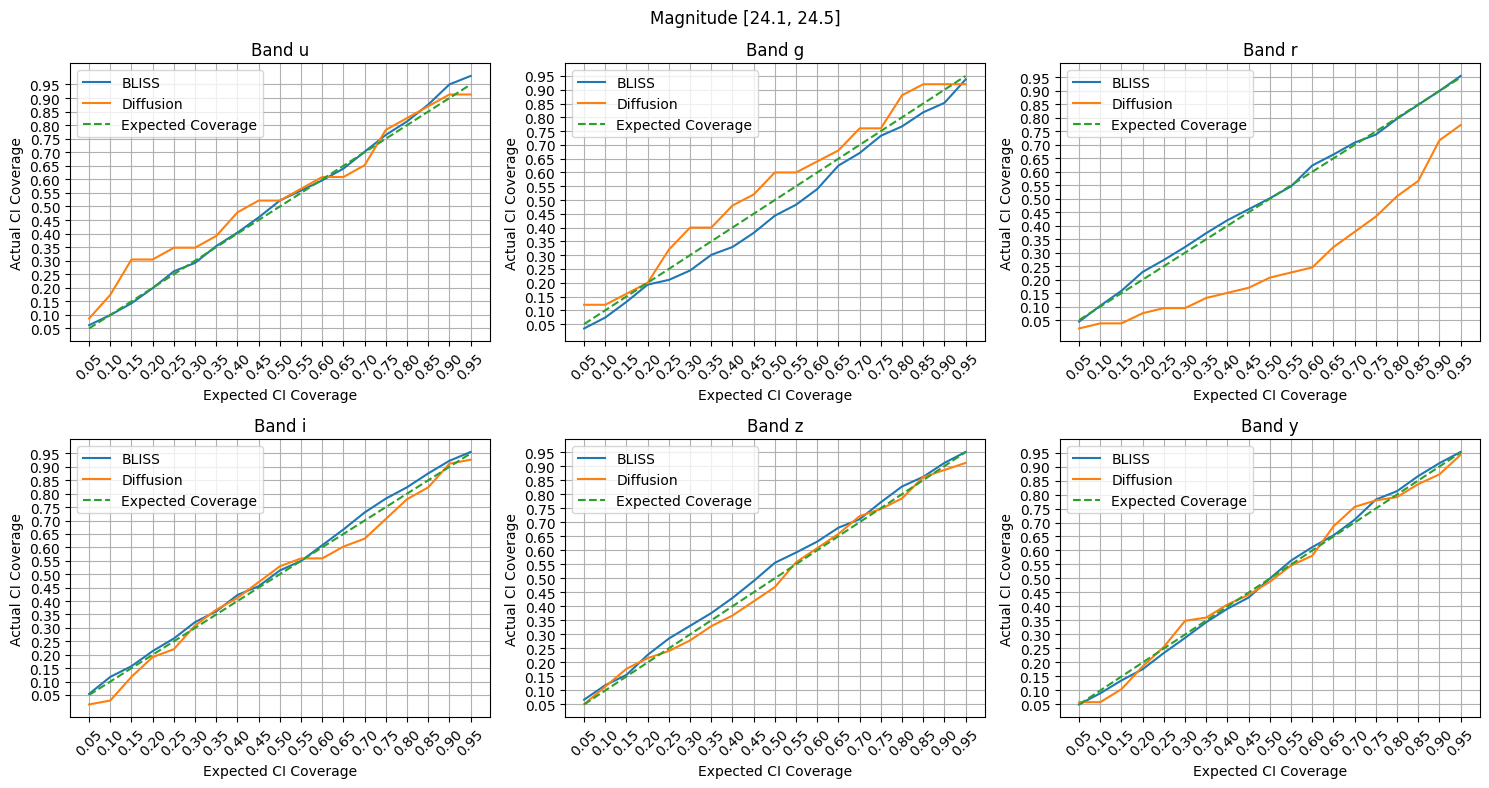

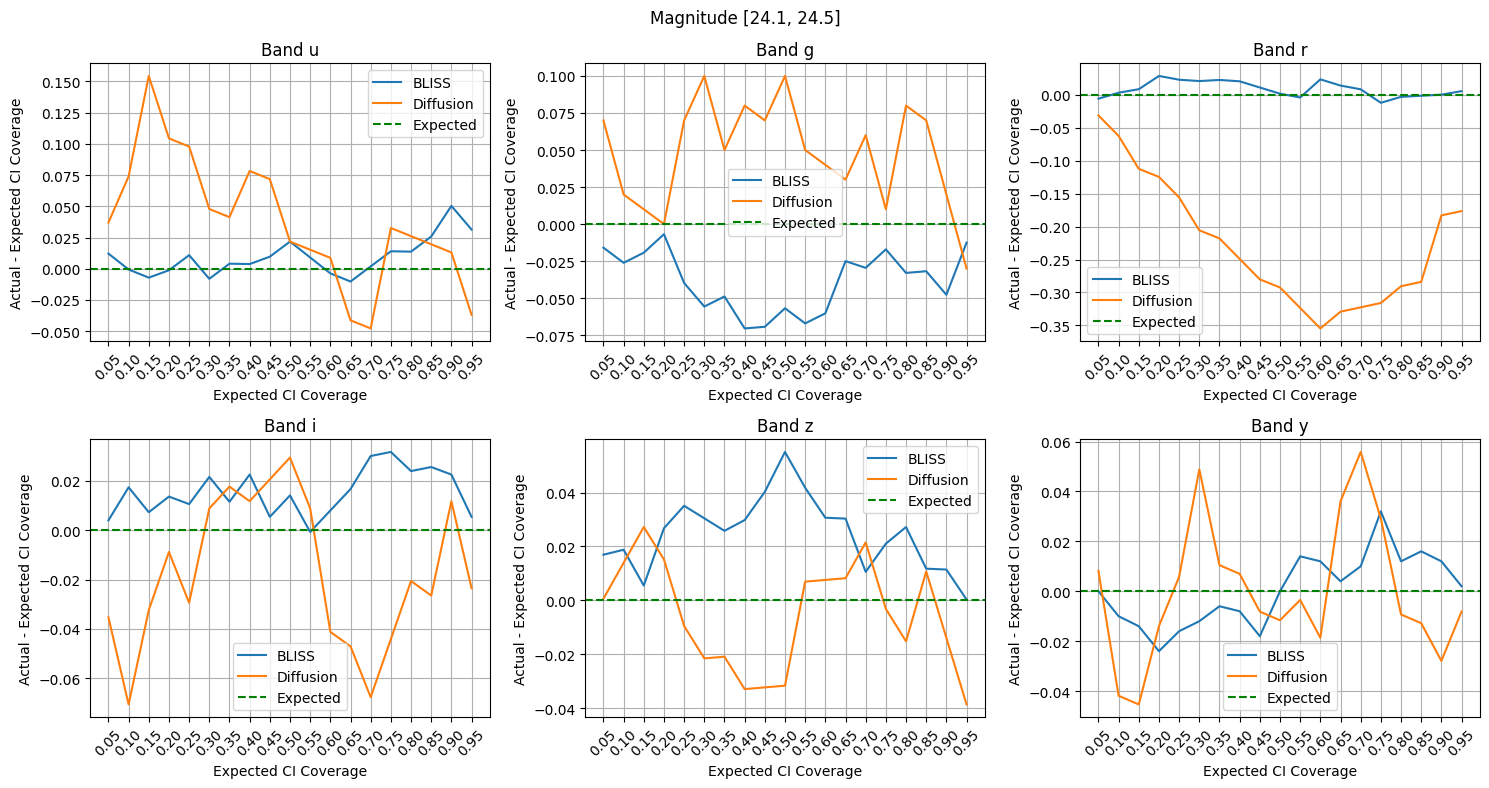

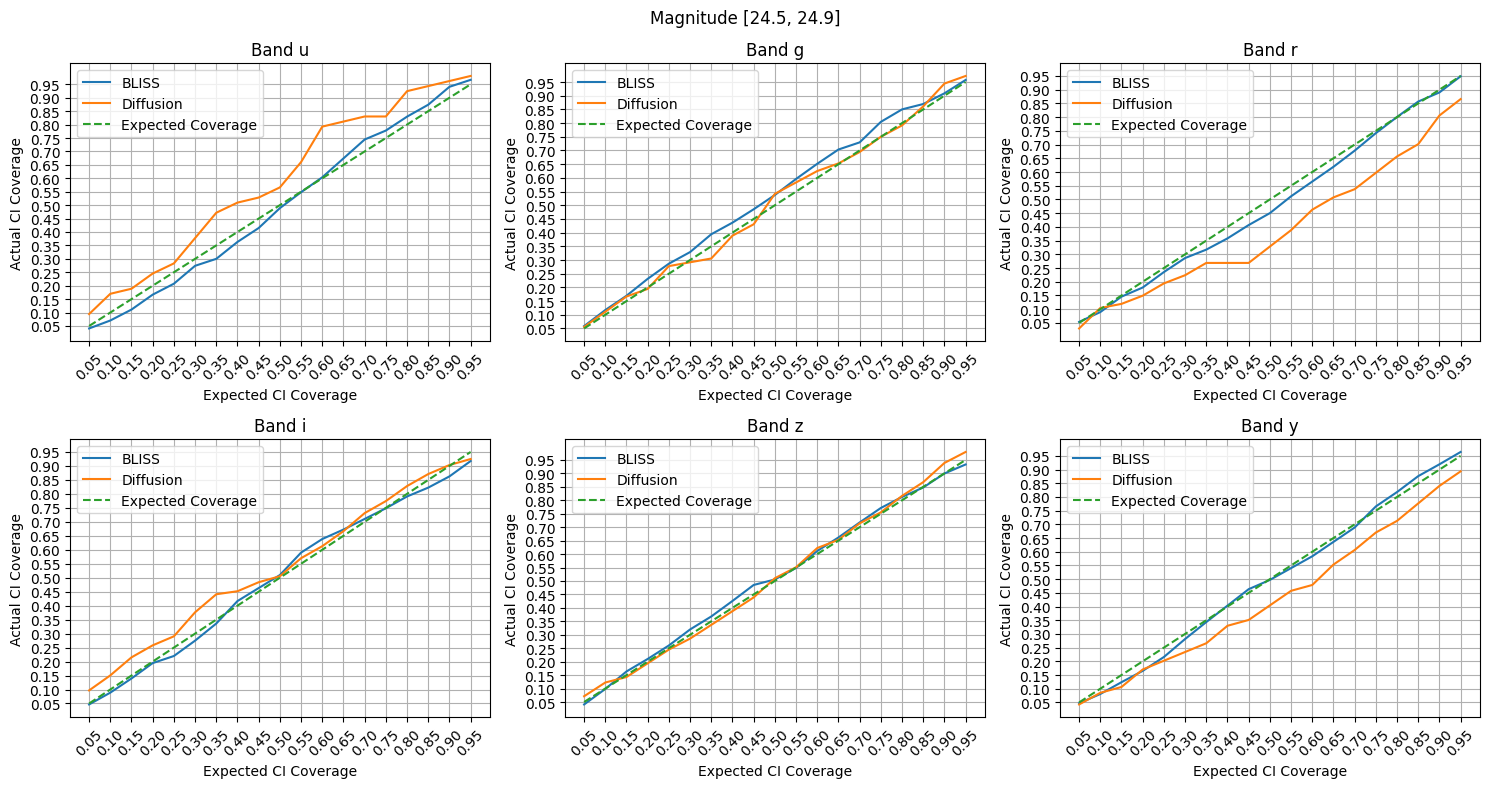

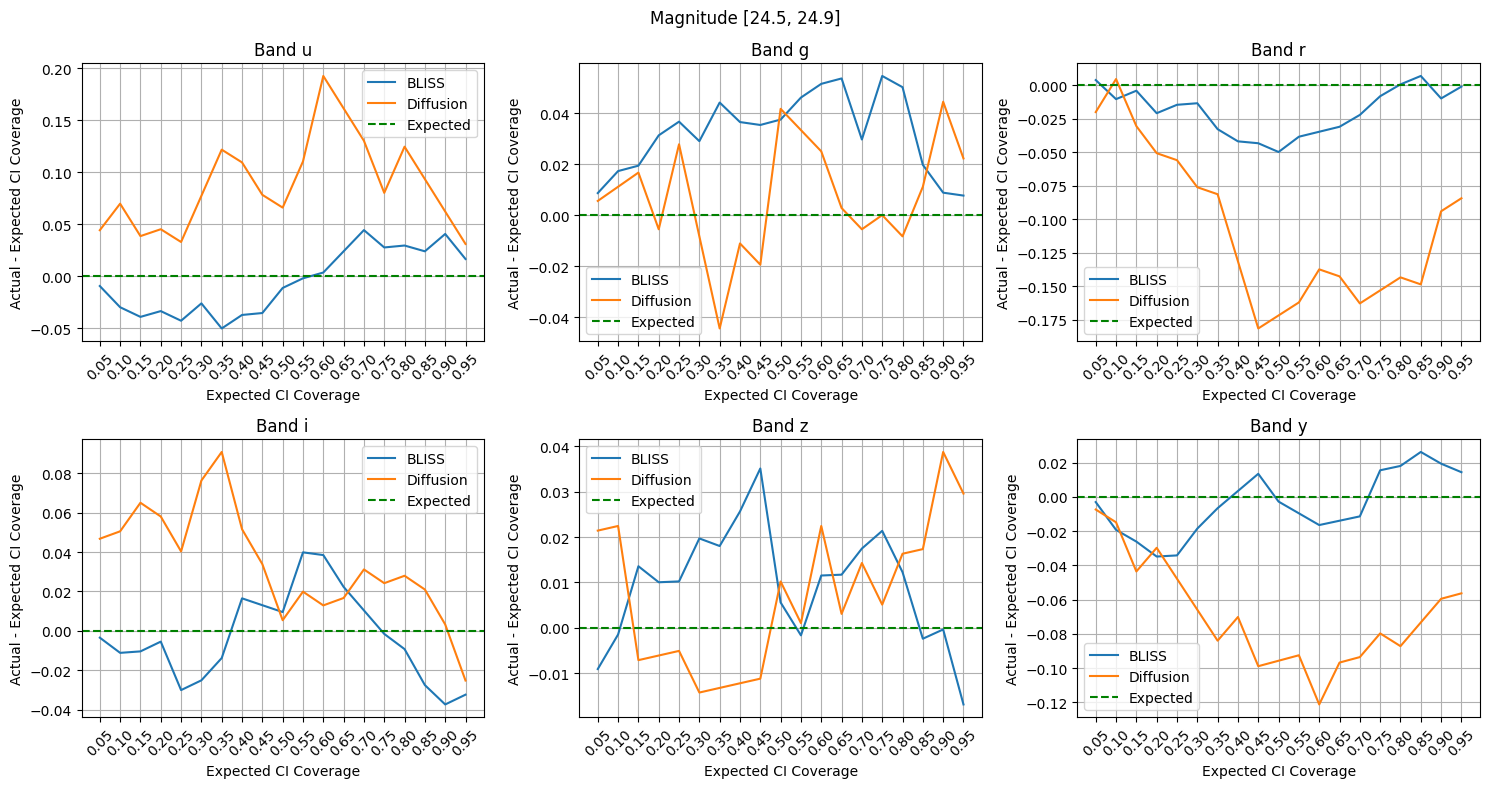

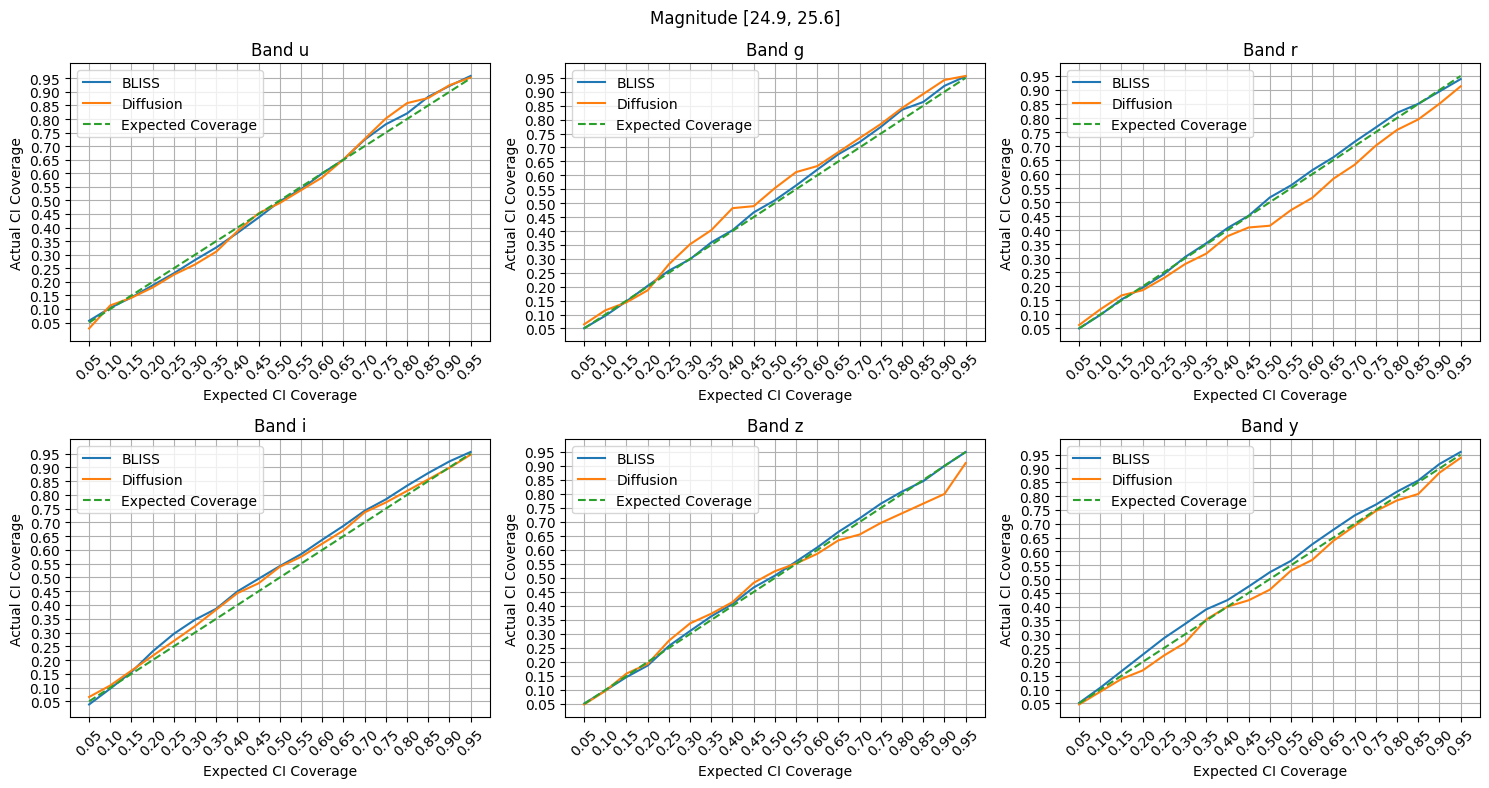

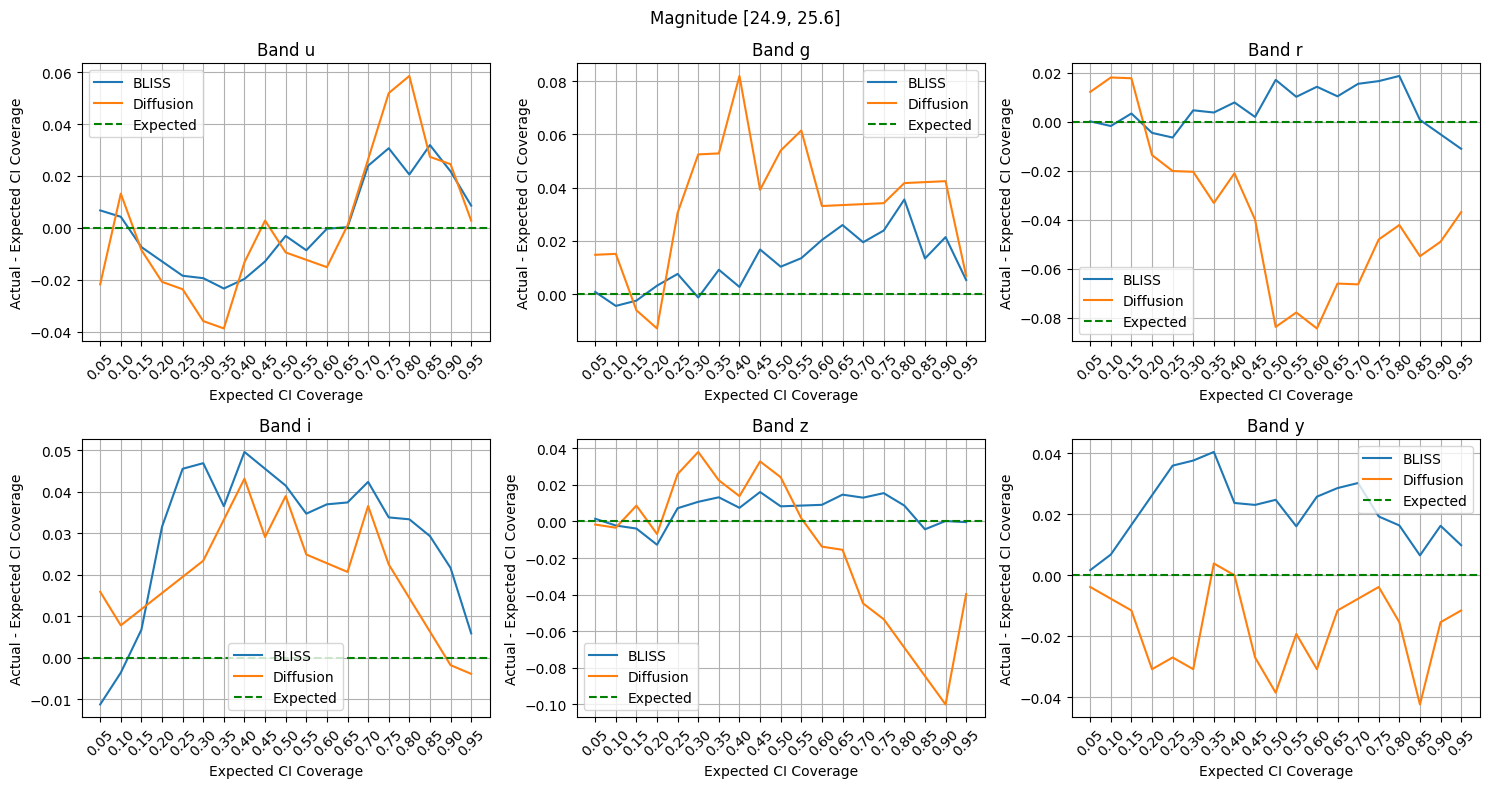

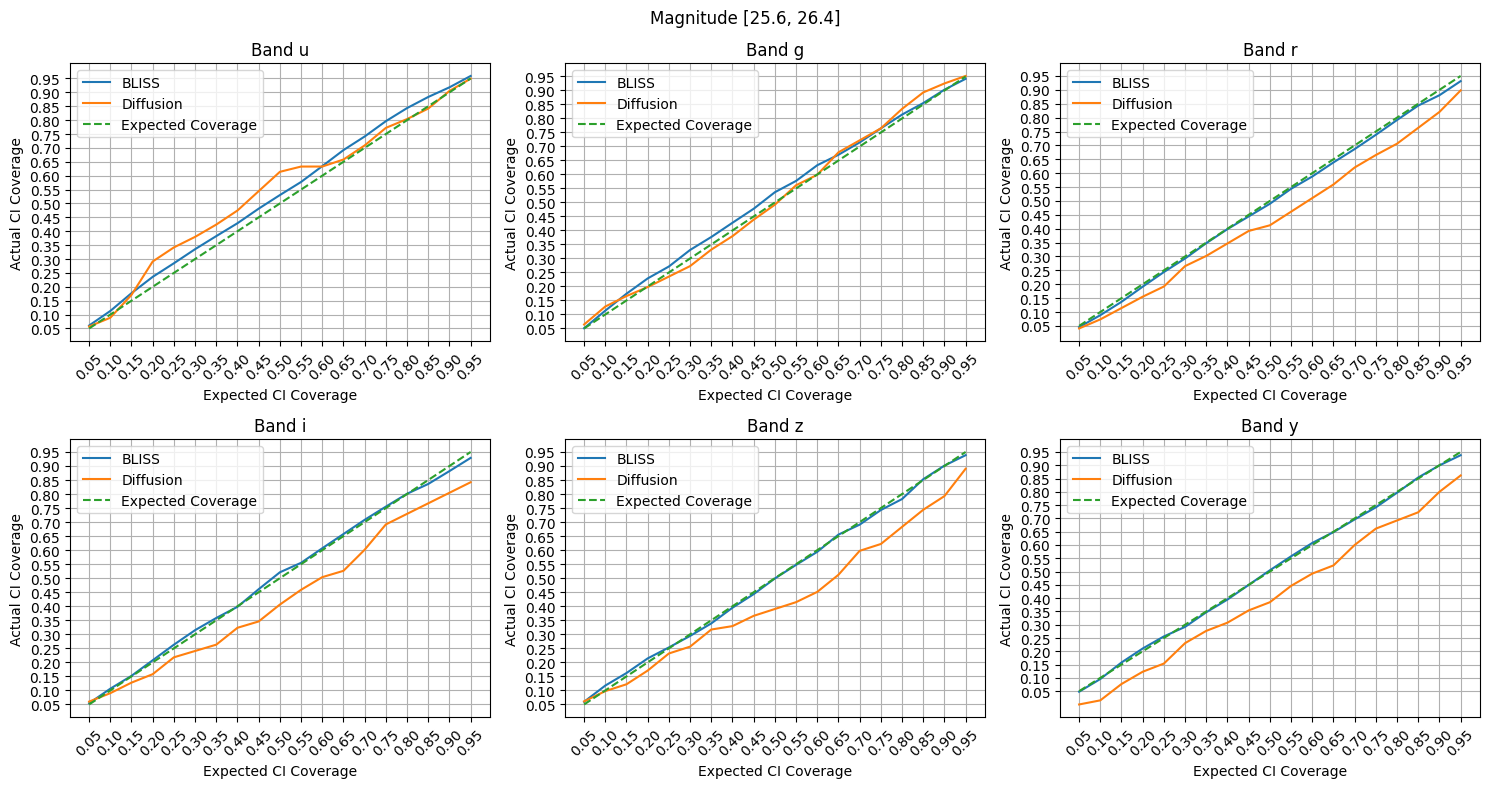

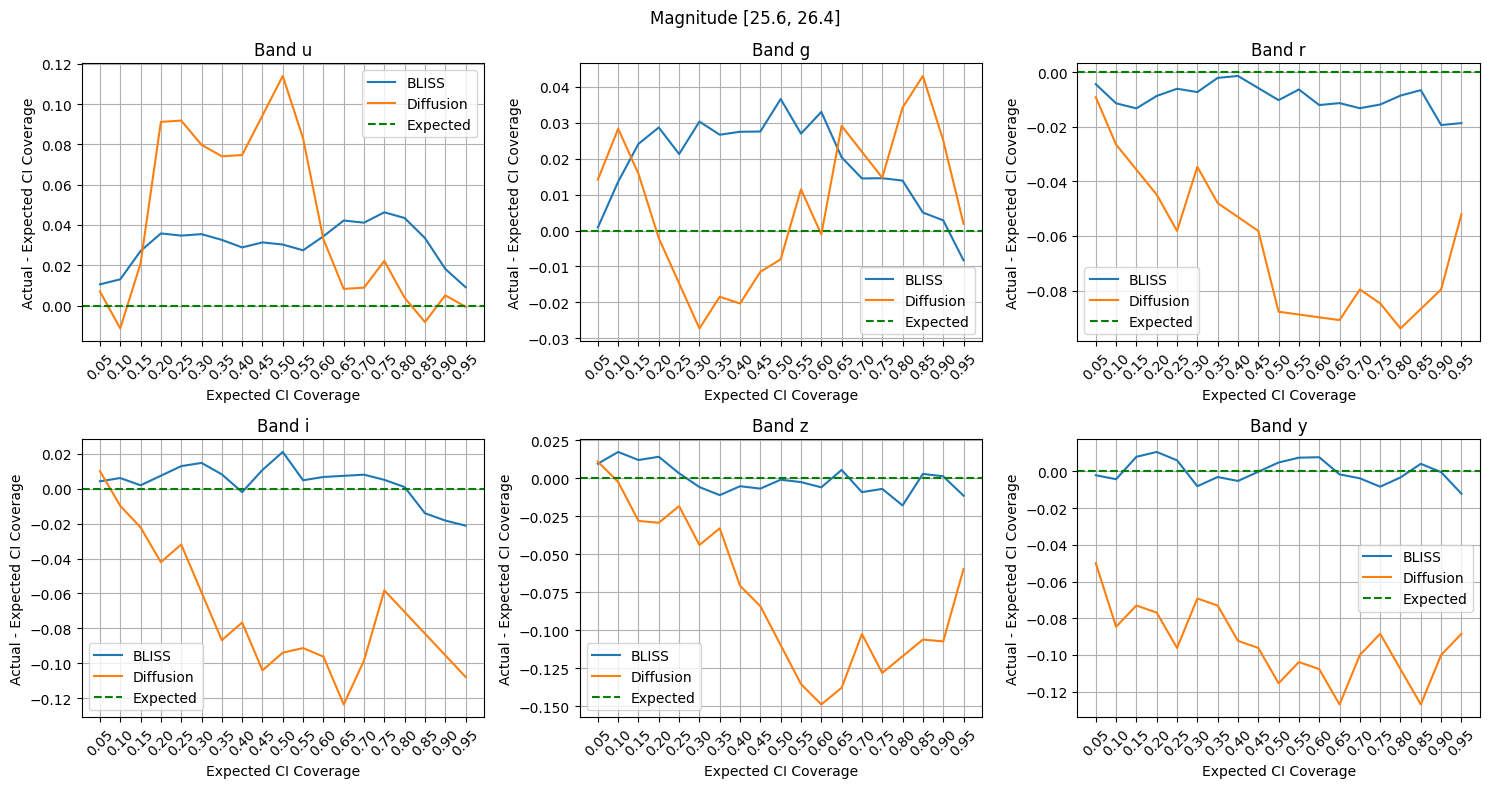

In [40]:
mag_boundaries = [-torch.inf, 23.9, 24.1, 24.5, 24.9, 25.6, 26.4]
for mag_min, mag_max in zip(mag_boundaries[:-1], mag_boundaries[1:]):
    plot_fluxes_ci(bliss_result_dict, diffusion_result_dict, flux_mag_min=mag_min, flux_mag_max=mag_max)

### Fluxes Correlation

In [41]:
def plot_data_for_fluxes_cor(result_dict):
    init_n_sources = result_dict["init_n_sources"]
    fluxes_list = result_dict["fluxes_list"]
    target_n_sources = result_dict["target_n_sources"]
    target_fluxes = result_dict["target_fluxes"]

    both_on_mask = (target_n_sources > 0) & (init_n_sources > 0)  # (b, h, w)
    all_fluxes = torch.cat(fluxes_list, dim=-2)  # (b, h, w, iter, 6)
    both_on_mask_iter_repeated = repeat(both_on_mask, 
                                        "b h w -> b h w iter k",
                                        iter=all_fluxes.shape[-2],
                                        k=all_fluxes.shape[-1])  # (b, h, w, iter, 6)
    both_on_mask_single_repeated = repeat(both_on_mask, 
                                        "b h w -> b h w 1 k",
                                        k=all_fluxes.shape[-1])  # (b, h, w, 1, 6)
    on_mask_fluxes = all_fluxes[both_on_mask_iter_repeated].view(-1, all_fluxes.shape[-2], 6)  # (matched_sources, iter, 6)
    target_on_mask_fluxes = target_fluxes[both_on_mask_single_repeated].view(-1, 6)  # (matched_sources, 6)

    return on_mask_fluxes, target_on_mask_fluxes

In [42]:
bliss_on_mask_fluxes, target_on_mask_fluxes = plot_data_for_fluxes_cor(bliss_result_dict)
diffusion_on_mask_fluxes, _target_on_mask_fluxes = plot_data_for_fluxes_cor(diffusion_result_dict)

In [43]:
assert (bliss_on_mask_fluxes.isnan().any(dim=-1) == bliss_on_mask_fluxes.isnan().all(dim=-1)).all()
assert (diffusion_on_mask_fluxes.isnan().any(dim=-1) == diffusion_on_mask_fluxes.isnan().all(dim=-1)).all()

In [44]:
bliss_on_mask_mag_df = pd.DataFrame(convert_flux_to_magnitude(bliss_on_mask_fluxes[:, :10, :].reshape(-1, 6), 
                                                              zero_point=3631e9),
                          columns=[f"Band {i}" for i in "ugrizy"])
diffusion_on_mask_mag_df = pd.DataFrame(convert_flux_to_magnitude(diffusion_on_mask_fluxes[:, :10, :].reshape(-1, 6), 
                                                                  zero_point=3631e9),
                          columns=[f"Band {i}" for i in "ugrizy"])
on_mask_target_mag_df = pd.DataFrame(convert_flux_to_magnitude(target_on_mask_fluxes, zero_point=3631e9),
                          columns=[f"Band {i}" for i in "ugrizy"])

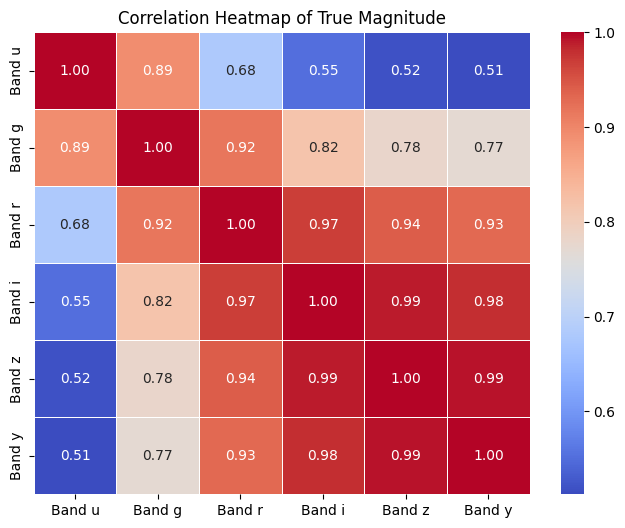

In [45]:
plt.figure(figsize=(8, 6))
sns.heatmap(on_mask_target_mag_df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of True Magnitude")
plt.show()

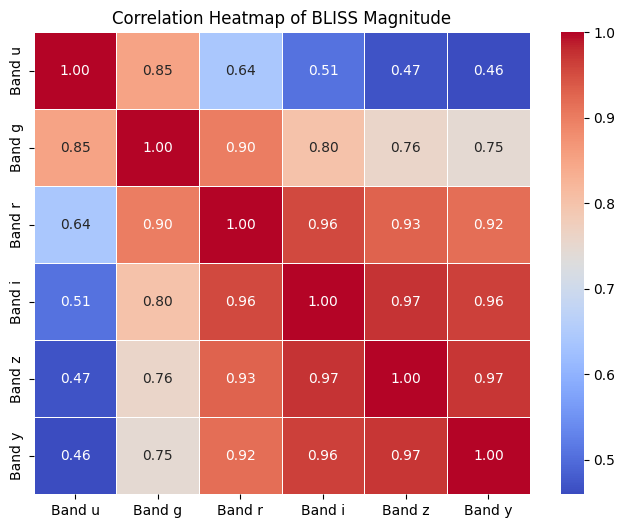

In [46]:
plt.figure(figsize=(8, 6))
sns.heatmap(bliss_on_mask_mag_df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of BLISS Magnitude")
plt.show()

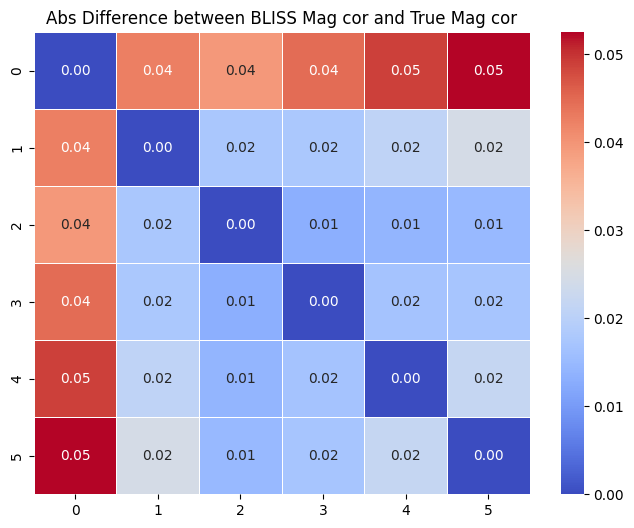

In [47]:
plt.figure(figsize=(8, 6))
sns.heatmap(np.abs(bliss_on_mask_mag_df.corr().to_numpy() - \
                   on_mask_target_mag_df.corr().to_numpy()), 
            annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Abs Difference between BLISS Mag cor and True Mag cor")
plt.show()

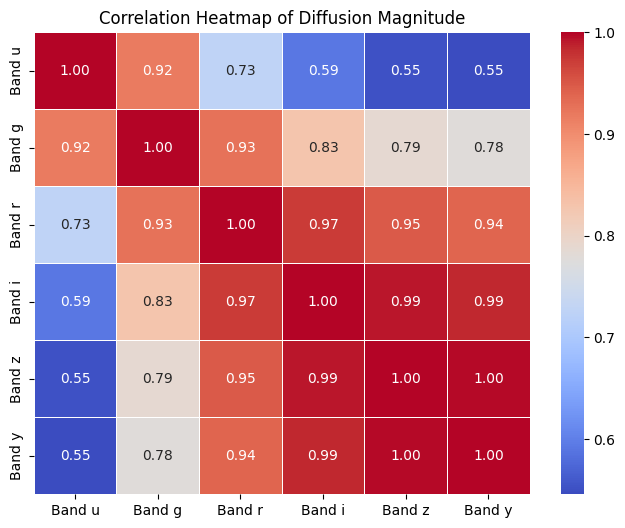

In [48]:
plt.figure(figsize=(8, 6))
sns.heatmap(diffusion_on_mask_mag_df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Diffusion Magnitude")
plt.show()

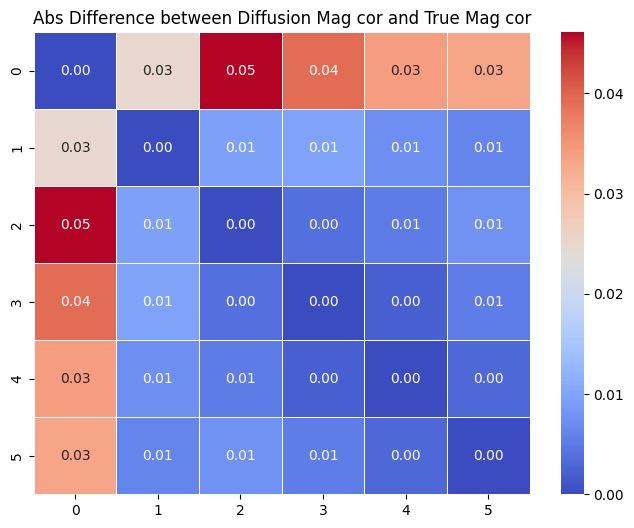

In [49]:
plt.figure(figsize=(8, 6))
sns.heatmap(np.abs(diffusion_on_mask_mag_df.corr().to_numpy() - \
                    on_mask_target_mag_df.corr().to_numpy()), 
            annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Abs Difference between Diffusion Mag cor and True Mag cor")
plt.show()

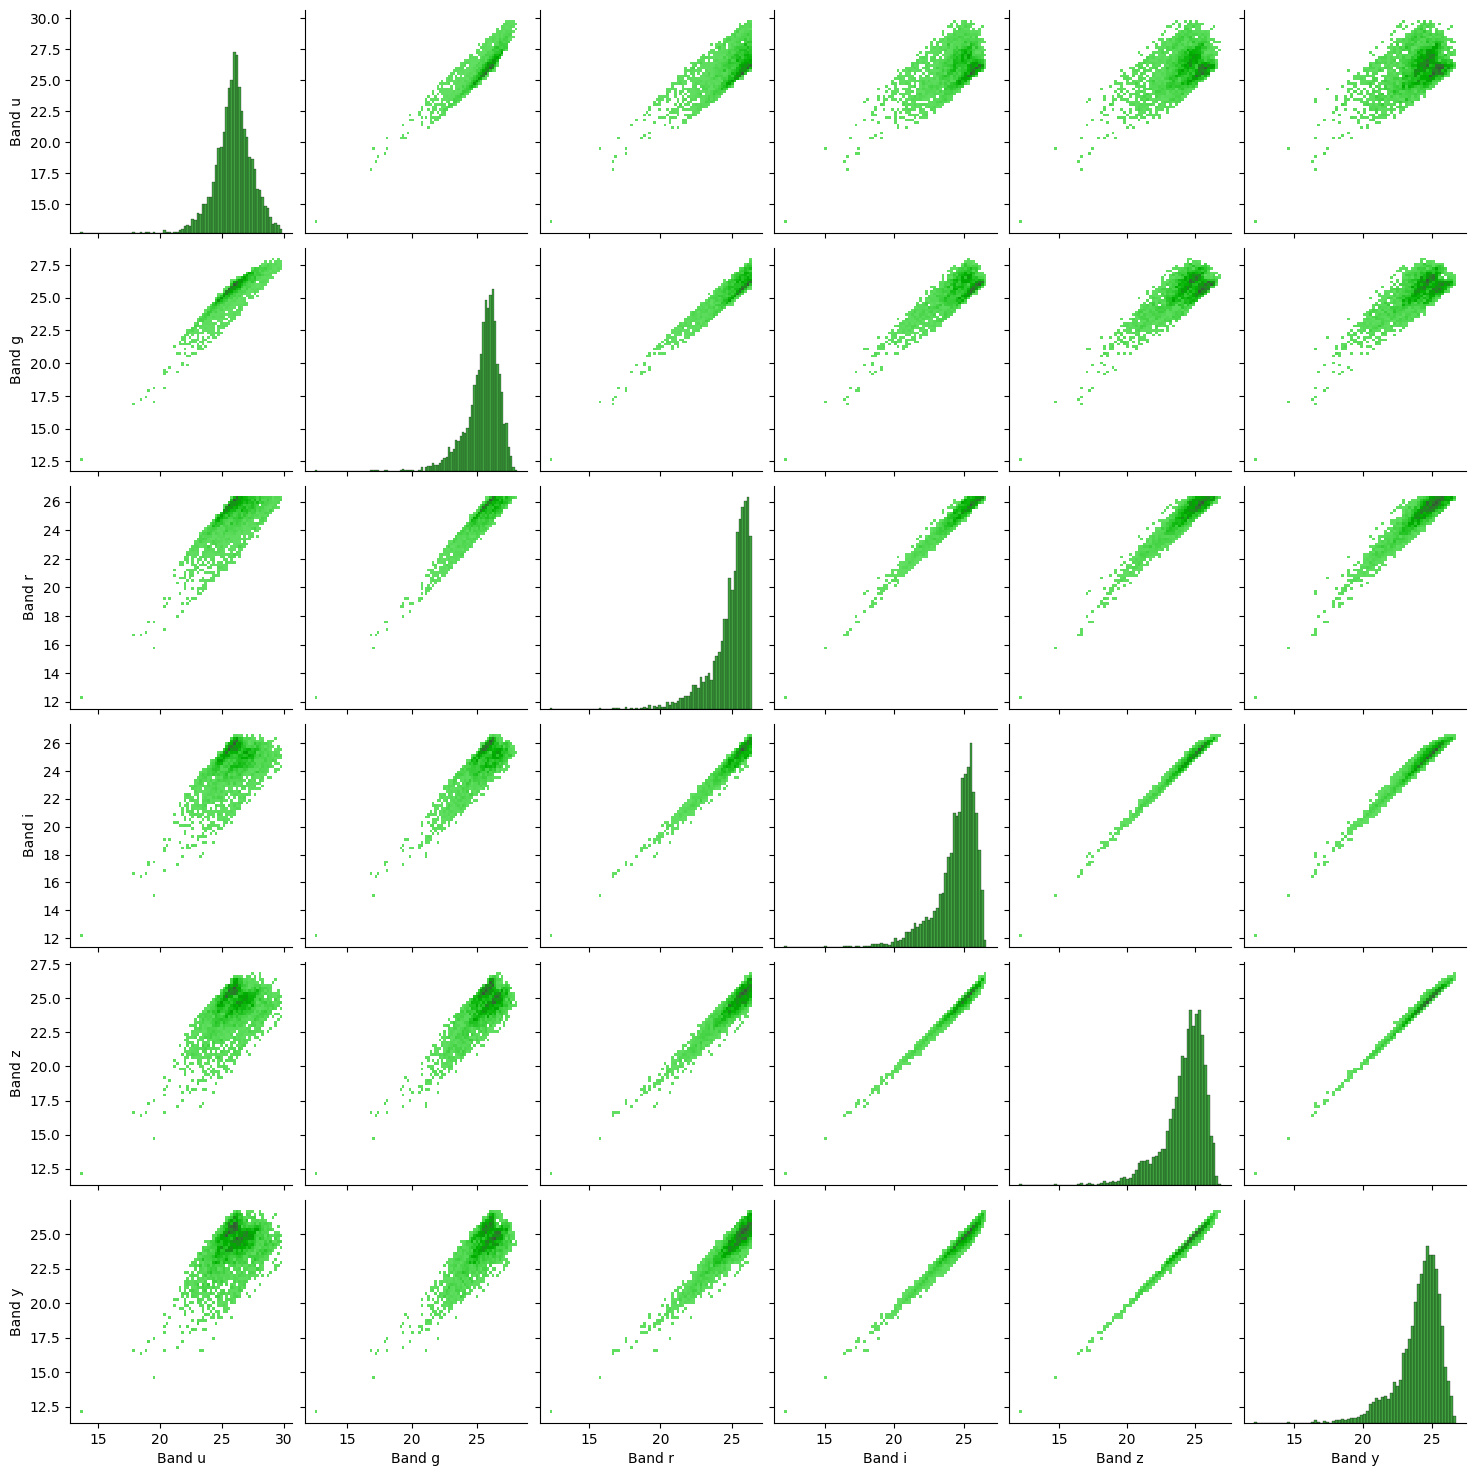

In [50]:
sns.pairplot(on_mask_target_mag_df, kind="hist", dropna=True,
             diag_kws={"color": "green"},
             plot_kws={"color": "green"})
plt.show()

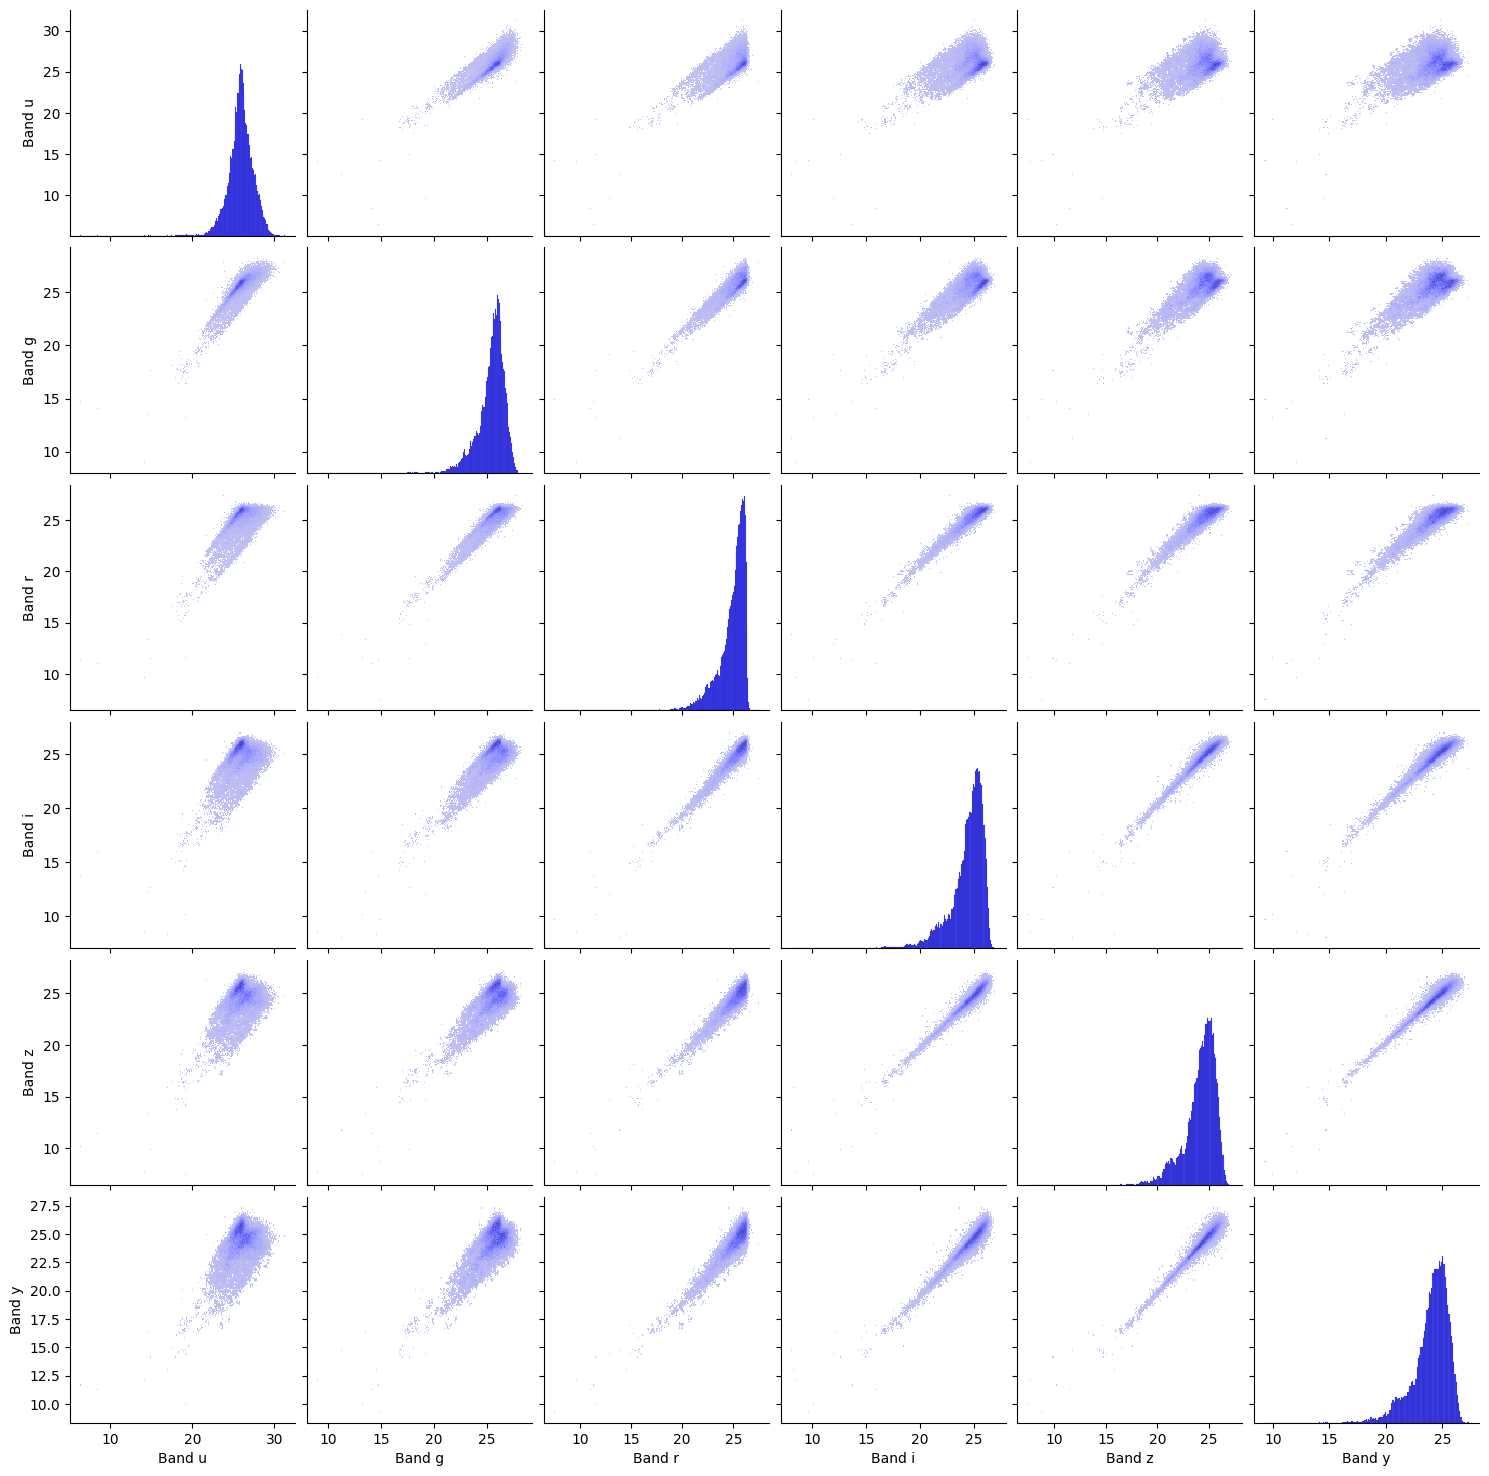

In [51]:
sns.pairplot(bliss_on_mask_mag_df, kind="hist", dropna=True,
             diag_kws={"color": "blue"},
             plot_kws={"color": "blue"})
plt.show()

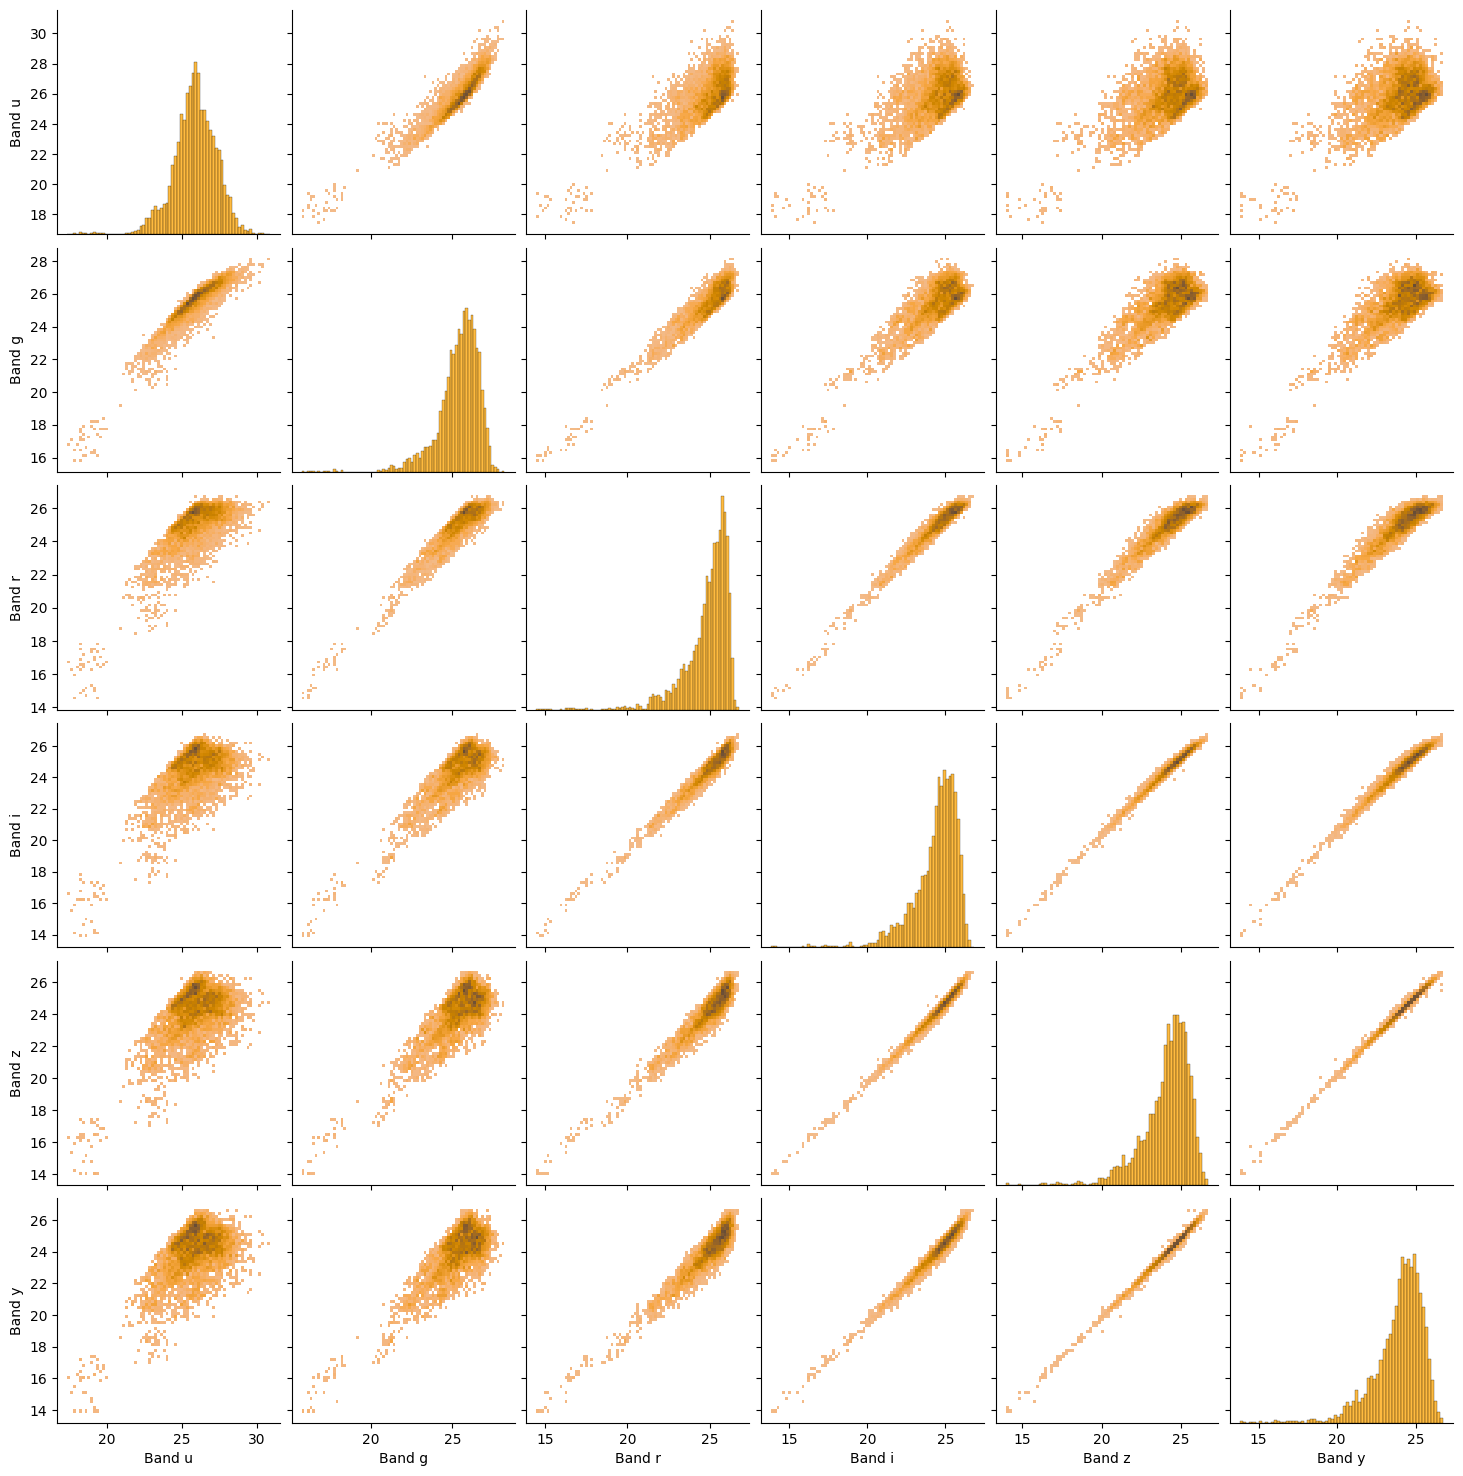

In [52]:
sns.pairplot(diffusion_on_mask_mag_df, kind="hist", dropna=True,
             diag_kws={"color": "orange"},
             plot_kws={"color": "orange"})
plt.show()